# Query revenue reports from Vertica

In [1]:
import getpass
host = 'office-vrt.taboolasyndication.com'
port = 5433
user_name = input("type the username:")
password = getpass.getpass("type the password")

type the username: allen.wu
type the password ·········


In [2]:
import pandas as pd
import vertica_python

conn_info = {'host': host,
             'port': port,
             'user': user_name,
             'password': password,
             # autogenerated session label by default,
             'session_label': 'some_label',
             # default throw error on invalid UTF-8 results
             'unicode_error': 'strict',
             # SSL is disabled by default
             'ssl': False,
             # autocommit is off by default
             'autocommit': True,
             # using server-side prepared statements is disabled by default
             'use_prepared_statements': False,
             # connection timeout is not enabled by default
             # 5 seconds timeout for a socket operation (Establishing a TCP connection or read/write operation)
             'connection_timeout': 300}

In [9]:
publisher_id = '1187,1325982,1201218,1010748,1038583,1144810,1010749,1147154,1038585,1198243,1168,1079980,1247031,1042437,1045582,1042054,1013679,1037854,1231839,1193912,1154953,1281185,1076408,1138898,1391079,1262914,1111116,1186367,1008941,1053067,1038711,1009152,1017950,1088305,1003870,1054686,1030939,1399538,1068427,1293316,1291813,1151165,1213551,1008942,1037850,1004592,1105715,1144834,1399536,1017946,1143314,1051651,1037842,1231844,1078972,1173726,1399530,1031855,724,1031845,1110515'
sql = """\
select 
cic.item_hash,
cic.publisher_id,
cic.campaign_type,
cic.title,
cic.item_type,
cic.impressions,
cic.clicks,
cic.clicks/cic.impressions as ctr,
cic.revenue,
cic.calibrated_clicks,
cic.calibrated_revenue,
cic.received_timestamp,
cl.name as taxonomy
from reports.target_level_sourced_for_affiliates_report_daily cic
inner join trc.item_clusters_prob icp on cic.item_hash = icp.item_id
inner join trc.clusters cl on icp.cluster_id = cl.id
where cic.received_timestamp between '{begin}' and '{end}'
and icp.algorithm like 'ALCHEMY_TAXONOMY'\
and cic.publisher_id in ({publisher_id})
""".format(begin='2022-02-01', end='2022-03-14', publisher_id=publisher_id)
print(sql)

select 
cic.item_hash,
cic.publisher_id,
cic.campaign_type,
cic.title,
cic.item_type,
cic.impressions,
cic.clicks,
cic.clicks/cic.impressions as ctr,
cic.revenue,
cic.calibrated_clicks,
cic.calibrated_revenue,
cic.received_timestamp,
cl.name as taxonomy
from reports.target_level_sourced_for_affiliates_report_daily cic
inner join trc.item_clusters_prob icp on cic.item_hash = icp.item_id
inner join trc.clusters cl on icp.cluster_id = cl.id
where cic.received_timestamp between '2022-02-01' and '2022-03-14'
and icp.algorithm like 'ALCHEMY_TAXONOMY'and cic.publisher_id in (1187,1325982,1201218,1010748,1038583,1144810,1010749,1147154,1038585,1198243,1168,1079980,1247031,1042437,1045582,1042054,1013679,1037854,1231839,1193912,1154953,1281185,1076408,1138898,1391079,1262914,1111116,1186367,1008941,1053067,1038711,1009152,1017950,1088305,1003870,1054686,1030939,1399538,1068427,1293316,1291813,1151165,1213551,1008942,1037850,1004592,1105715,1144834,1399536,1017946,1143314,1051651,1037842,1231844

In [10]:
%%time
with vertica_python.connect(**conn_info) as conn:
    cur = conn.cursor()
    cur.execute(sql)
    revenue_results = cur.fetchall()

CPU times: user 15min 28s, sys: 1min 46s, total: 17min 14s
Wall time: 20min 2s


In [11]:
df = pd.DataFrame(revenue_results, columns=['item_hash', 'publisher_id', 'campaign_type', 'title', 'item_type', 'impressions', 'clicks', 'ctr', 'revenue', 'calibrated_clicks', 'calibrated_revenue', 'received_timestamp',  'taxonomy'])

In [12]:
df.loc[df.ctr == 0E-18, 'ctr'] = 0

In [13]:
df['Date'] = pd.to_datetime(df["received_timestamp"]).dt.date

In [14]:
df

,item_hash,publisher_id,campaign_type,title,item_type,impressions,clicks,ctr,revenue,calibrated_clicks,calibrated_revenue,received_timestamp,taxonomy,Date
0,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,177,0,0,0.000000,0,0.000000,2022-02-15 20:00:36,/business and industrial/company,2022-02-15
1,7792233817584357870,1076408,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,26,1,0.038461538461538462,0.158574,1,0.158574,2022-02-23 20:00:27,/business and industrial/company,2022-02-23
2,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,121,0,0,0.000000,0,0.000000,2022-02-24 20:01:08,/business and industrial/company,2022-02-24
3,7792233817584357870,1076408,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,9,1,0.111111111111111111,0.134623,1,0.134623,2022-02-14 20:00:12,/business and industrial/company,2022-02-14
4,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,129,0,0,0.000000,0,0.000000,2022-03-07 20:00:16,/business and industrial/company,2022-03-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267303,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,279,1,0.003584229390681004,0.065457,1,0.065457,2022-03-11 20:01:09,/health and fitness/disease/deafness,2022-03-11
20267304,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,396,3,0.007575757575757576,0.199591,3,0.199591,2022-03-08 20:00:40,/health and fitness/disease/deafness,2022-03-08
20267305,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,749,6,0.008010680907877170,0.395792,6,0.395792,2022-03-10 20:00:49,/health and fitness/disease/deafness,2022-03-10
20267306,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,190,2,0.010526315789473684,0.144850,2,0.144850,2022-03-06 20:00:19,/health and fitness/disease/deafness,2022-03-06


# Overall analysis (61 publishers)

In [15]:
import datetime 

df_A = df[(df['Date']>datetime.date(2022,1,31)) & (df['Date']<datetime.date(2022,2,15))]
df_X1 = df_A.groupby(['publisher_id'])['revenue'].sum().reset_index()

publisher_id = df_X1['publisher_id'].to_list()
revenue_X1 = df_X1['revenue']

df_B = df[(df['Date']>datetime.date(2022,2,14)) & (df['Date']<datetime.date(2022,3,1))]
df_X2 = df_B.groupby(['publisher_id'])['revenue'].sum().reset_index()

revenue_X2 = df_X2['revenue']

df_C = df[(df['Date']>datetime.date(2022,2,28)) & (df['Date']<datetime.date(2022,3,14))]
df_X3 = df_C.groupby(['publisher_id'])['revenue'].sum().reset_index()

revenue_X3 = df_X3['revenue']

In [21]:
df_C

,item_hash,publisher_id,campaign_type,title,item_type,impressions,clicks,ctr,revenue,calibrated_clicks,calibrated_revenue,received_timestamp,taxonomy,Date
4,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,129,0,0,0.000000,0,0.000000,2022-03-07 20:00:16,/business and industrial/company,2022-03-07
5,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,119,0,0,0.000000,0,0.000000,2022-03-06 20:00:19,/business and industrial/company,2022-03-06
15,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,113,0,0,0.000000,0,0.000000,2022-03-01 20:01:25,/business and industrial/company,2022-03-01
20,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,189,0,0,0.000000,0,0.000000,2022-03-01 20:01:25,/business and industrial/company,2022-03-01
31,7792233817584357870,1076408,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,20,1,0.050000000000000000,0.157622,1,0.157622,2022-03-07 20:00:16,/business and industrial/company,2022-03-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267303,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,279,1,0.003584229390681004,0.065457,1,0.065457,2022-03-11 20:01:09,/health and fitness/disease/deafness,2022-03-11
20267304,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,396,3,0.007575757575757576,0.199591,3,0.199591,2022-03-08 20:00:40,/health and fitness/disease/deafness,2022-03-08
20267305,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,749,6,0.008010680907877170,0.395792,6,0.395792,2022-03-10 20:00:49,/health and fitness/disease/deafness,2022-03-10
20267306,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,190,2,0.010526315789473684,0.144850,2,0.144850,2022-03-06 20:00:19,/health and fitness/disease/deafness,2022-03-06


In [17]:
df_X2

,publisher_id,revenue
0,724,22040.681001
1,1168,282394.207514
2,1187,438617.518064
3,1003870,40888.116279
4,1004592,20147.130069
...,...,...
56,1325982,81470.150729
57,1391079,75593.565172
58,1399530,25607.101046
59,1399536,24924.338826


In [18]:
df_X3

,publisher_id,revenue
0,724,14782.573383
1,1168,267241.013735
2,1187,413955.512732
3,1003870,25153.564915
4,1004592,15885.303507
...,...,...
56,1325982,83282.791894
57,1391079,60715.032443
58,1399530,21440.077905
59,1399536,19784.451672


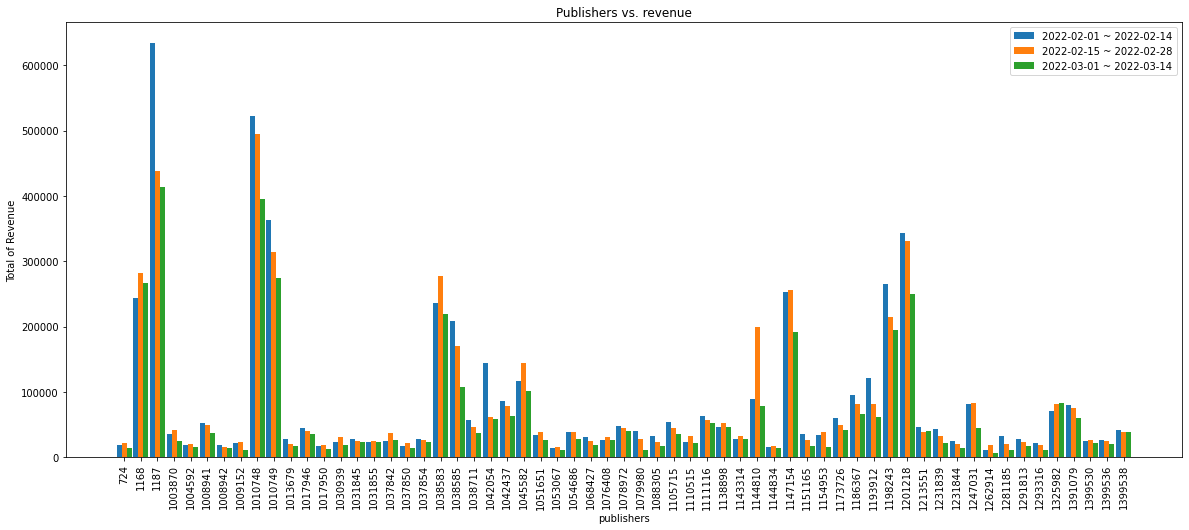

In [19]:
import numpy as np 
import matplotlib.pyplot as plt 

label1 = '2022-02-01 ~ 2022-02-14'
label2 = '2022-02-15 ~ 2022-02-28'
label3 = '2022-03-01 ~ 2022-03-14'
X_axis = np.arange(len(publisher_id))
plt.figure(figsize=(20,8))
plt.bar(X_axis - 0.3, revenue_X1, 0.3, label = label1)
plt.bar(X_axis + 0, revenue_X2, 0.3, label = label2)
plt.bar(X_axis + 0.3, revenue_X3, 0.3, label = label3)

plt.xticks(X_axis, publisher_id, rotation=90)
plt.xlabel("publishers")
plt.ylabel("Total of Revenue")
plt.title("Publishers vs. revenue")

plt.legend()
plt.rcParams.update({'font.size': 8})

In [22]:
revenue_date_df = df.groupby(['Date'])['revenue'].sum().reset_index()

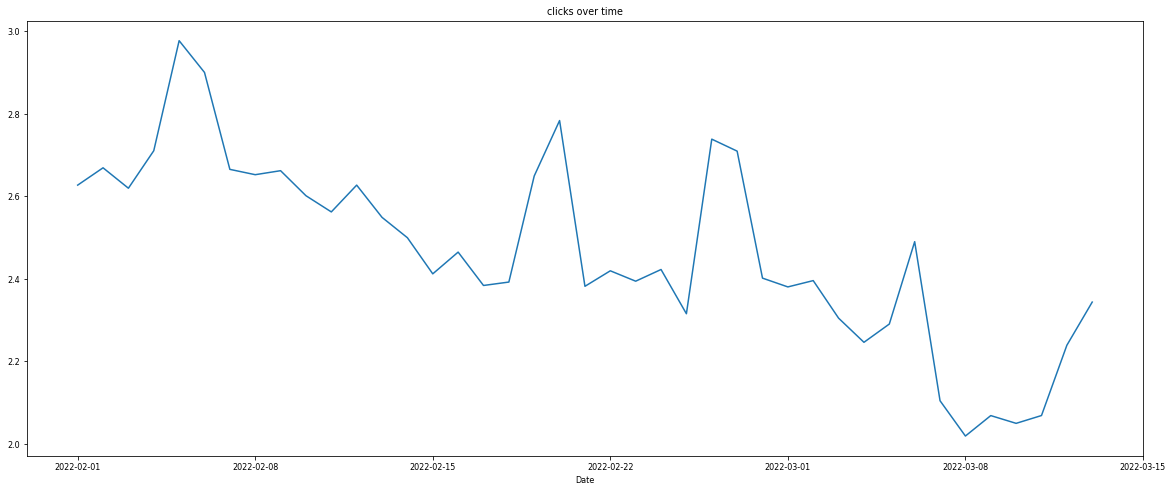

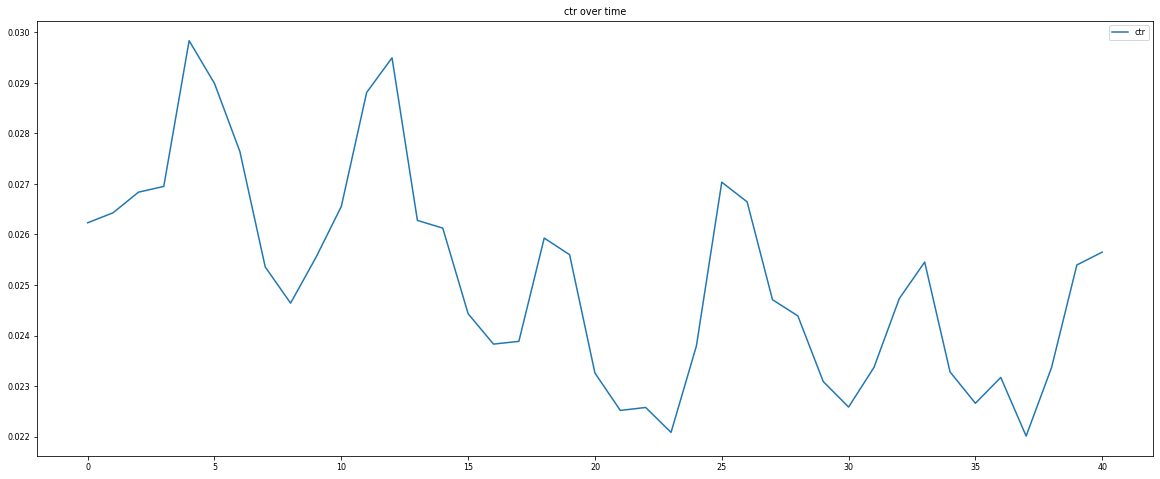

In [23]:
import matplotlib as plt

%matplotlib inline

plt.rcParams.update({'font.size': 8})

df.groupby(['Date'])['clicks'].mean().plot(kind = 'line', figsize=(20,8), title='clicks over time')

df.groupby(['Date'])['ctr'].apply(np.mean).reset_index().plot(kind = 'line', figsize=(20,8), title='ctr over time')

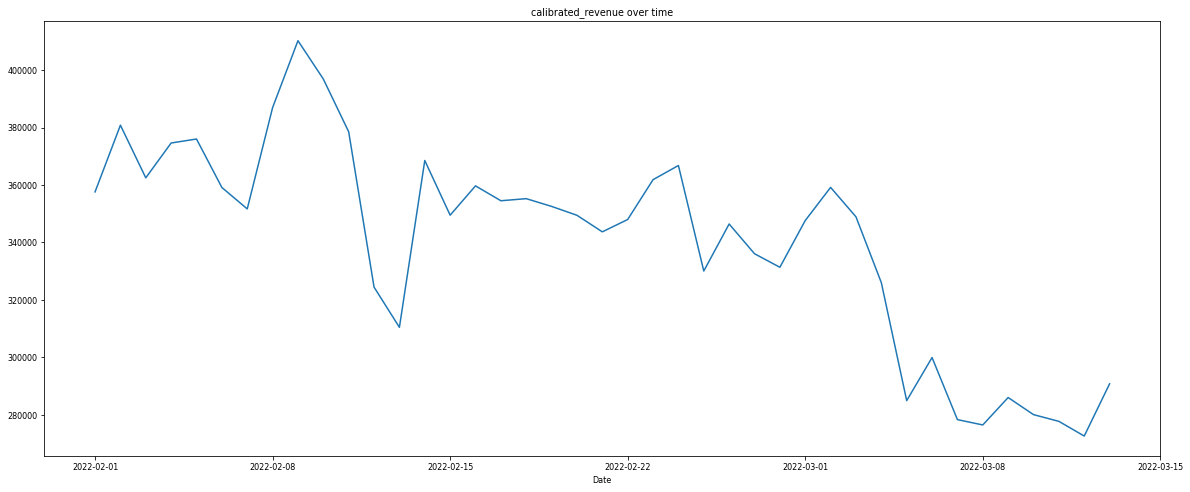

In [24]:
import matplotlib as plt

%matplotlib inline

plt.rcParams.update({'font.size': 8})

df.groupby(['Date'])['calibrated_revenue'].sum().plot(kind = 'line', figsize=(20,8), title='calibrated_revenue over time')

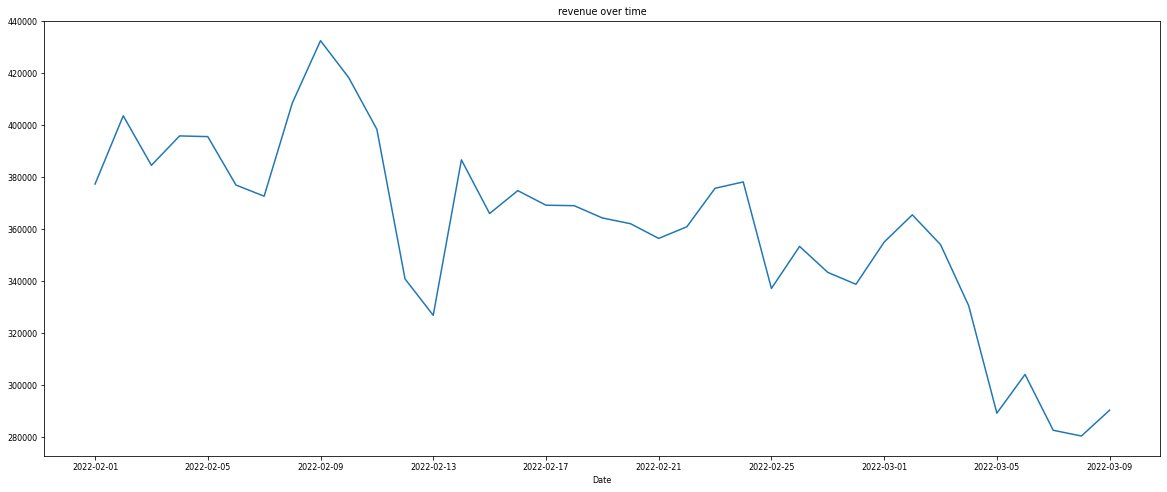

In [19]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df.groupby(['Date'])['revenue'].sum().plot(kind = 'line', figsize=(20,8), title='revenue over time')

# NBC analysis

In [25]:
df_nbc = df[df['publisher_id'].isin([1010748])]
df_nbc

,item_hash,publisher_id,campaign_type,title,item_type,impressions,clicks,ctr,revenue,calibrated_clicks,calibrated_revenue,received_timestamp,taxonomy,Date
2,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,121,0,0,0.000,0,0.000,2022-02-24 20:01:08,/business and industrial/company,2022-02-24
5,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,119,0,0,0.000,0,0.000,2022-03-06 20:00:19,/business and industrial/company,2022-03-06
8,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,128,0,0,0.000,0,0.000,2022-02-10 20:00:21,/business and industrial/company,2022-02-10
13,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,146,0,0,0.000,0,0.000,2022-02-17 20:00:46,/business and industrial/company,2022-02-17
15,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,113,0,0,0.000,0,0.000,2022-03-01 20:01:25,/business and industrial/company,2022-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20264871,-7147735704269823724,1010748,SPONSORED,特集「進化するテレワークセキュリティ」,Video,424,0,0,0.000,0,0.000,2022-03-02 20:00:23,/technology and computing/computer security/ne...,2022-03-02
20264879,-7147735704269823724,1010748,SPONSORED,特集「進化するテレワークセキュリティ」,Video,103,0,0,0.000,0,0.000,2022-02-18 20:00:46,/technology and computing/computer security/ne...,2022-02-18
20266030,-8868241873664353296,1010748,SPONSORED,Hur man enkelt tar bort öronvax,Video,109,1,0.009174311926605505,0.028,1,0.028,2022-03-13 20:00:23,/health and fitness/disease/deafness,2022-03-13
20266031,-8868241873664353296,1010748,SPONSORED,Hur man enkelt tar bort öronvax,Video,142,0,0,0.000,0,0.000,2022-03-12 20:00:56,/health and fitness/disease/deafness,2022-03-12


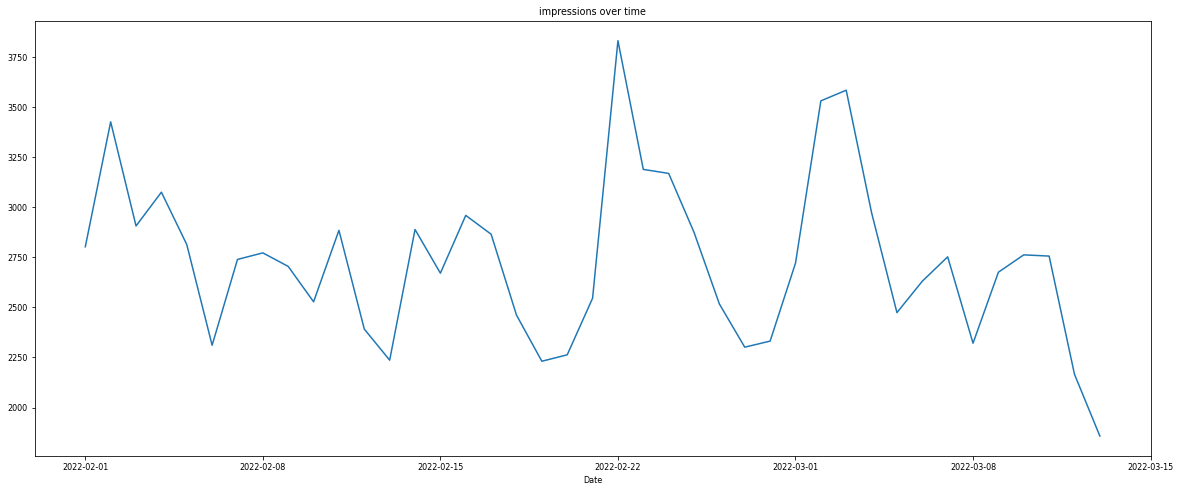

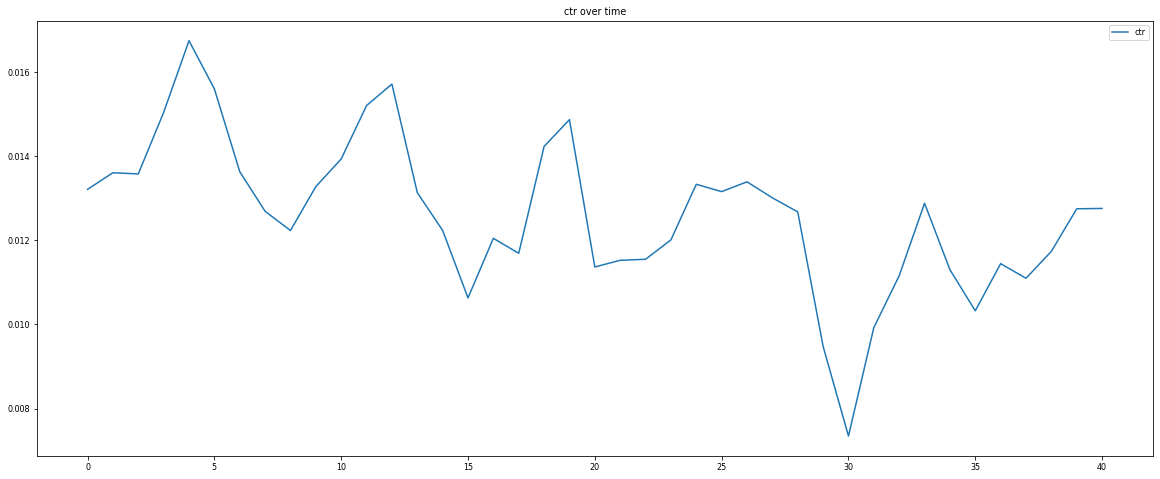

In [26]:
import matplotlib as plt

%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_nbc.groupby(['Date'])['impressions'].mean().plot(kind = 'line', figsize=(20,8), title='impressions over time')

df_nbc.groupby(['Date'])['ctr'].apply(np.mean).reset_index().plot(kind = 'line', figsize=(20,8), title='ctr over time')

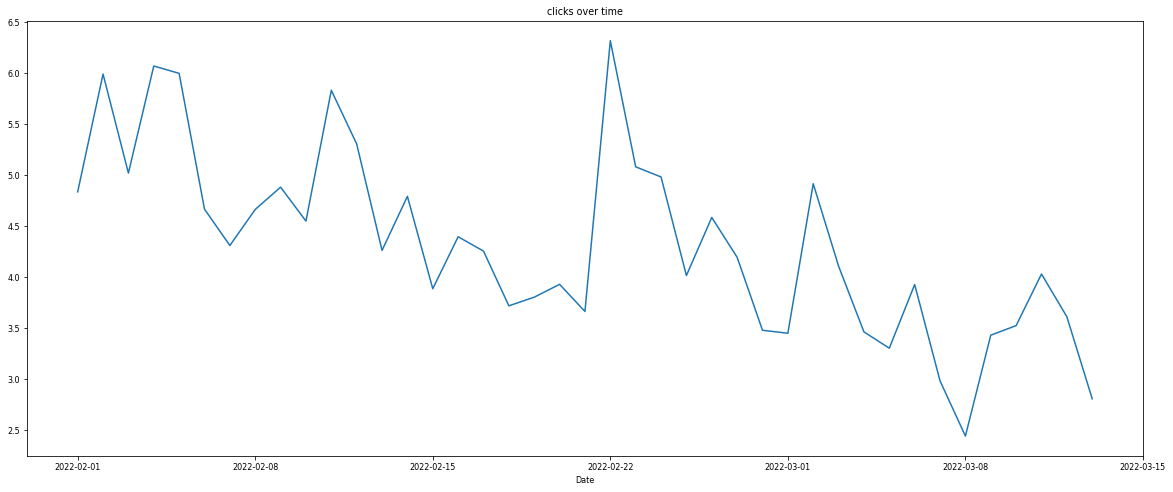

In [27]:
df_nbc.groupby(['Date'])['clicks'].mean().plot(kind = 'line', figsize=(20,8), title='clicks over time')

In [28]:
df_nbc_ctr = df_nbc.groupby(['Date'])['ctr'].apply(np.mean).reset_index()
df_nbc_ctr

,Date,ctr
0,2022-02-01,0.013210
1,2022-02-02,0.013603
2,2022-02-03,0.013575
3,2022-02-04,0.015037
4,2022-02-05,0.016742
5,2022-02-06,0.015596
6,2022-02-07,0.013630
7,2022-02-08,0.012688
8,2022-02-09,0.012231
9,2022-02-10,0.013274


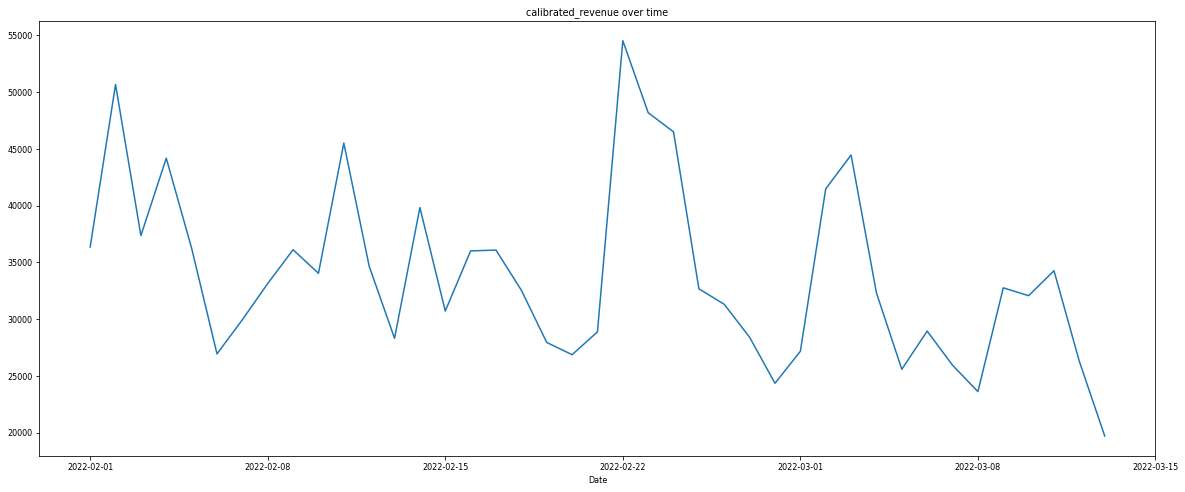

In [29]:
import matplotlib as plt

%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_nbc.groupby(['Date'])['calibrated_revenue'].sum().plot(kind = 'line', figsize=(20,8), title='calibrated_revenue over time')

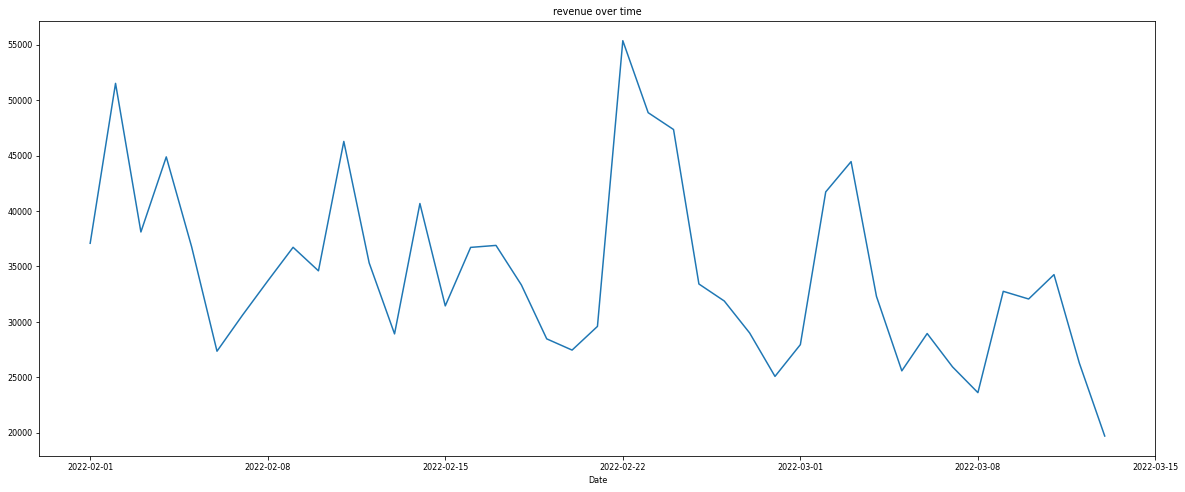

In [30]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_nbc.groupby(['Date'])['revenue'].sum().plot(kind = 'line', figsize=(20,8), title='revenue over time')

In [34]:
df_0213_nbc = df_nbc[(df_nbc['Date']>datetime.date(2022,1,31)) & (df_nbc['Date']<datetime.date(2022,2,15))]
revenue_lists = df_0213_nbc['revenue'].tolist()
percentile_bucket = normalize_revenue(revenue_lists)
df_0213_nbc['percentile'] = percentile_bucket

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


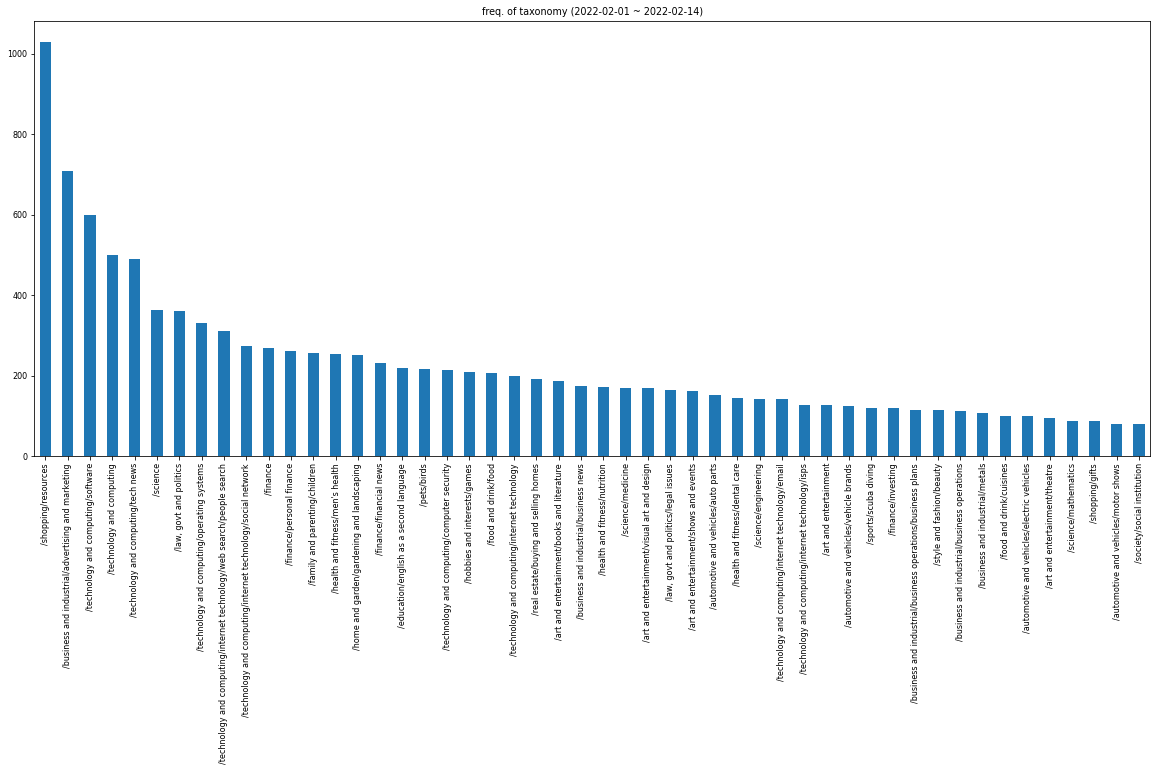

In [35]:
%matplotlib inline
bucket = ['p99', 'p95']
df_0213_p99_nbc = df_0213_nbc[df_0213_nbc.percentile.isin(bucket)]

plt.rcParams.update({'font.size': 8})

df_0213_p99_nbc['taxonomy'].value_counts()[:50].plot(kind = 'bar', figsize=(20,8), title='freq. of taxonomy (2022-02-01 ~ 2022-02-14)')

In [37]:
df_0228_nbc = df_nbc[(df_nbc['Date']>datetime.date(2022,2,14)) & (df_nbc['Date']<datetime.date(2022,3,1))]
revenue_lists = df_0228_nbc['revenue'].tolist()
percentile_bucket = normalize_revenue(revenue_lists)
df_0228_nbc['percentile'] = percentile_bucket

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


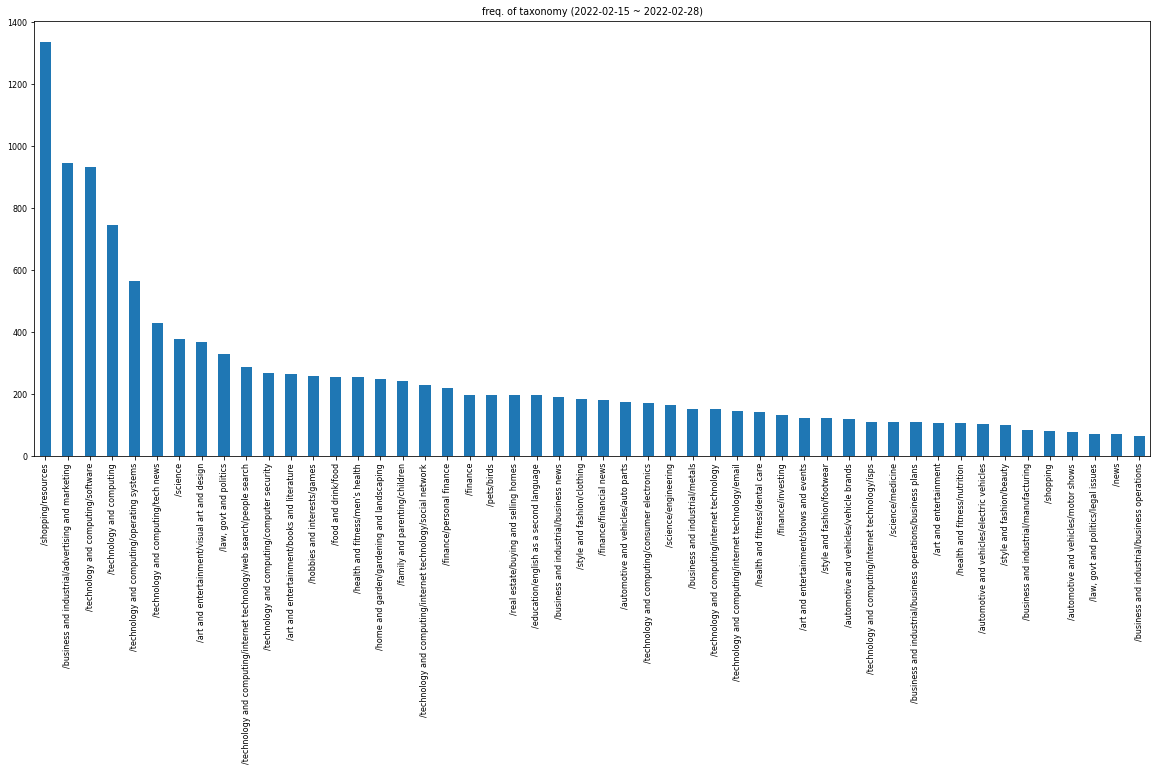

In [38]:
%matplotlib inline
bucket = ['p99','p95']
df_0228_p99_nbc = df_0228_nbc[df_0228_nbc.percentile.isin(bucket)]

plt.rcParams.update({'font.size': 8})

df_0228_p99_nbc['taxonomy'].value_counts()[:50].plot(kind = 'bar', figsize=(20,8), title='freq. of taxonomy (2022-02-15 ~ 2022-02-28)')

# MSN Windows Analysis

In [39]:
df_msn_windows = df[df['publisher_id'].isin([1079980])]
df_msn_windows

,item_hash,publisher_id,campaign_type,title,item_type,impressions,clicks,ctr,revenue,calibrated_clicks,calibrated_revenue,received_timestamp,taxonomy,Date
605,-5114614695718329453,1079980,SPONSORED,Who Is the Richest Member of The British Royal...,Video,39,2,0.051282051282051282,0.018265,2,0.018265,2022-02-15 20:00:36,/business and industrial/company,2022-02-15
1509,-3283909269934130156,1079980,SPONSORED,The biggest hair growth breakthrough in decades,Video,3,1,0.333333333333333333,0.658309,1,0.658309,2022-02-27 20:01:14,/business and industrial/company,2022-02-27
3085,493034613294193196,1079980,SPONSORED,10 Overlooked Tax Deductions to Know Before Yo...,Video,85,1,0.011764705882352941,0.305807,1,0.305807,2022-02-26 20:00:51,/business and industrial/company,2022-02-26
3096,493034613294193196,1079980,SPONSORED,10 Overlooked Tax Deductions to Know Before Yo...,Video,103,0,0,0.000000,0,0.000000,2022-02-27 20:01:14,/business and industrial/company,2022-02-27
3388,493034613294193196,1079980,SPONSORED,10 Overlooked Tax Deductions to Know Before Yo...,Video,117,0,0,0.000000,0,0.000000,2022-03-05 20:01:09,/business and industrial/company,2022-03-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250592,8134834192352047215,1079980,SPONSORED,9 NFL Teams Passed On Patrick Mahomes - See Wh...,Video,140,3,0.021428571428571429,0.299370,3,0.299370,2022-02-05 20:00:07,/careers/career planning,2022-02-05
20250621,1002078240166662418,1079980,SPONSORED,9 NFL Teams Passed On Patrick Mahomes - See Wh...,Video,6,1,0.166666666666666667,0.170258,1,0.170258,2022-02-25 20:01:02,/careers/career planning,2022-02-25
20250953,-8643016786470446791,1079980,SPONSORED,Ranked: The Biggest Draft Busts In NFL History,Video,82,2,0.024390243902439024,0.263961,2,0.263961,2022-03-13 20:00:23,/careers/career planning,2022-03-13
20258184,-6197258765276476325,1079980,SPONSORED,Look: Top 5 best pick-up trucks 2022 | Autocar,Video,1,1,1.000000000000000000,0.010000,1,0.010000,2022-03-01 20:01:25,/technology and computing/computer security/ne...,2022-03-01


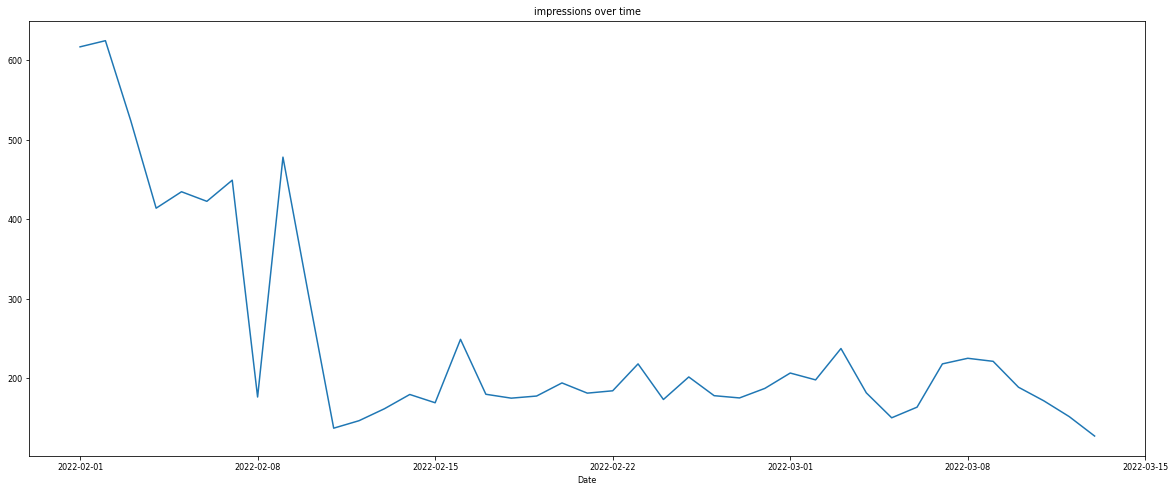

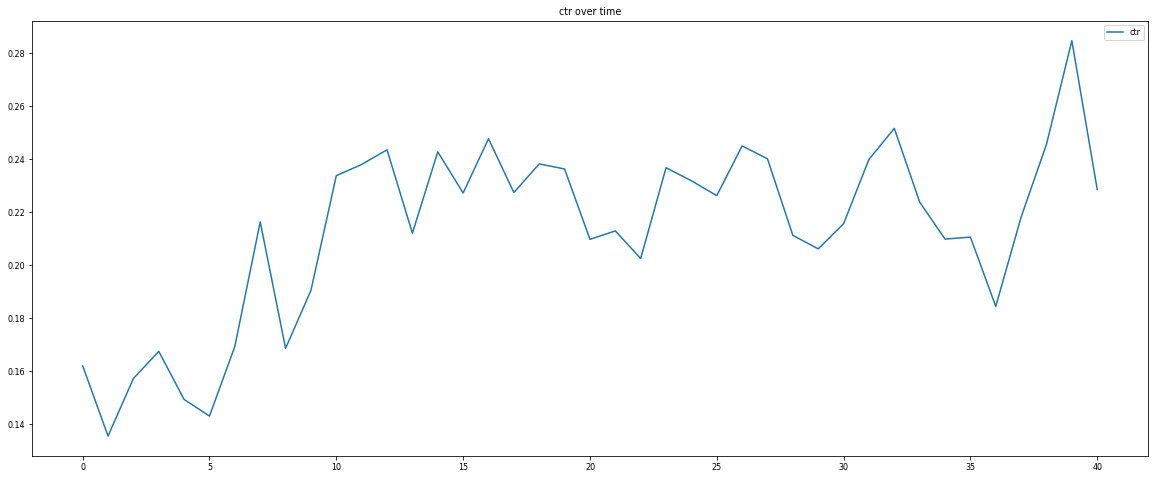

In [40]:
import matplotlib as plt

%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_msn_windows.groupby(['Date'])['impressions'].mean().plot(kind = 'line', figsize=(20,8), title='impressions over time')

df_msn_windows.groupby(['Date'])['ctr'].apply(np.mean).reset_index().plot(kind = 'line', figsize=(20,8), title='ctr over time')

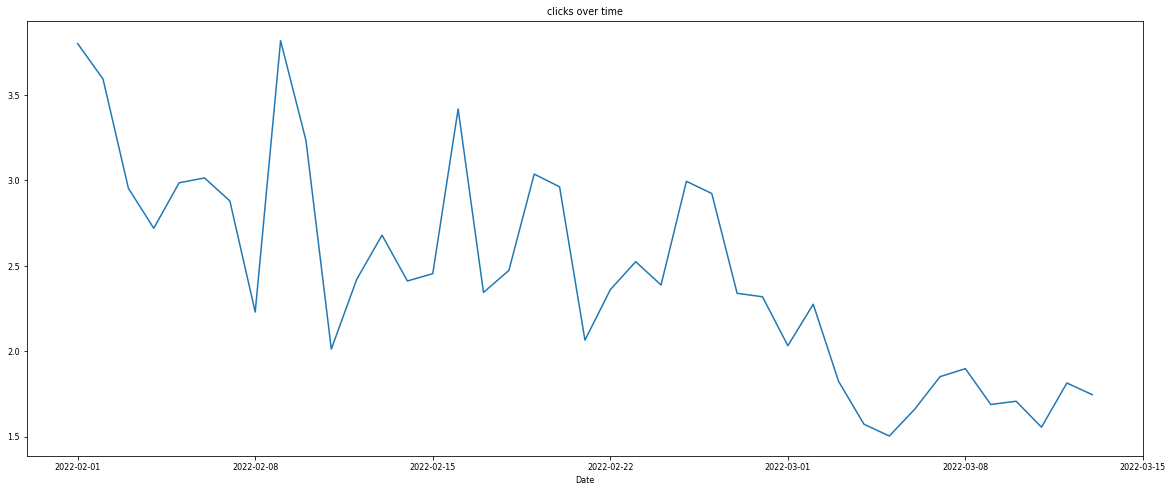

In [41]:
df_msn_windows.groupby(['Date'])['clicks'].mean().plot(kind = 'line', figsize=(20,8), title='clicks over time')

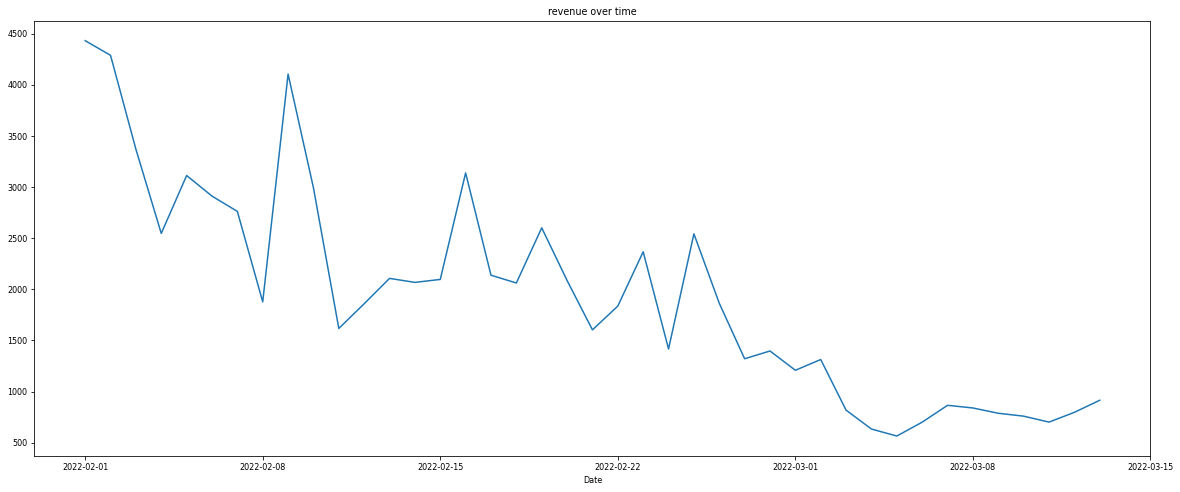

In [42]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_msn_windows.groupby(['Date'])['revenue'].sum().plot(kind = 'line', figsize=(20,8), title='revenue over time')

In [43]:
df_0213_msn = df_msn_windows[(df_msn_windows['Date']>datetime.date(2022,1,31)) & (df_msn_windows['Date']<datetime.date(2022,2,15))]
revenue_lists = df_0213_msn['revenue'].tolist()
percentile_bucket = normalize_revenue(revenue_lists)
df_0213_msn['percentile'] = percentile_bucket

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
df_0228_msn = df_msn_windows[(df_msn_windows['Date']>datetime.date(2022,2,14)) & (df_msn_windows['Date']<datetime.date(2022,3,1))]
revenue_lists = df_0228_msn['revenue'].tolist()
percentile_bucket = normalize_revenue(revenue_lists)
df_0228_msn['percentile'] = percentile_bucket

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


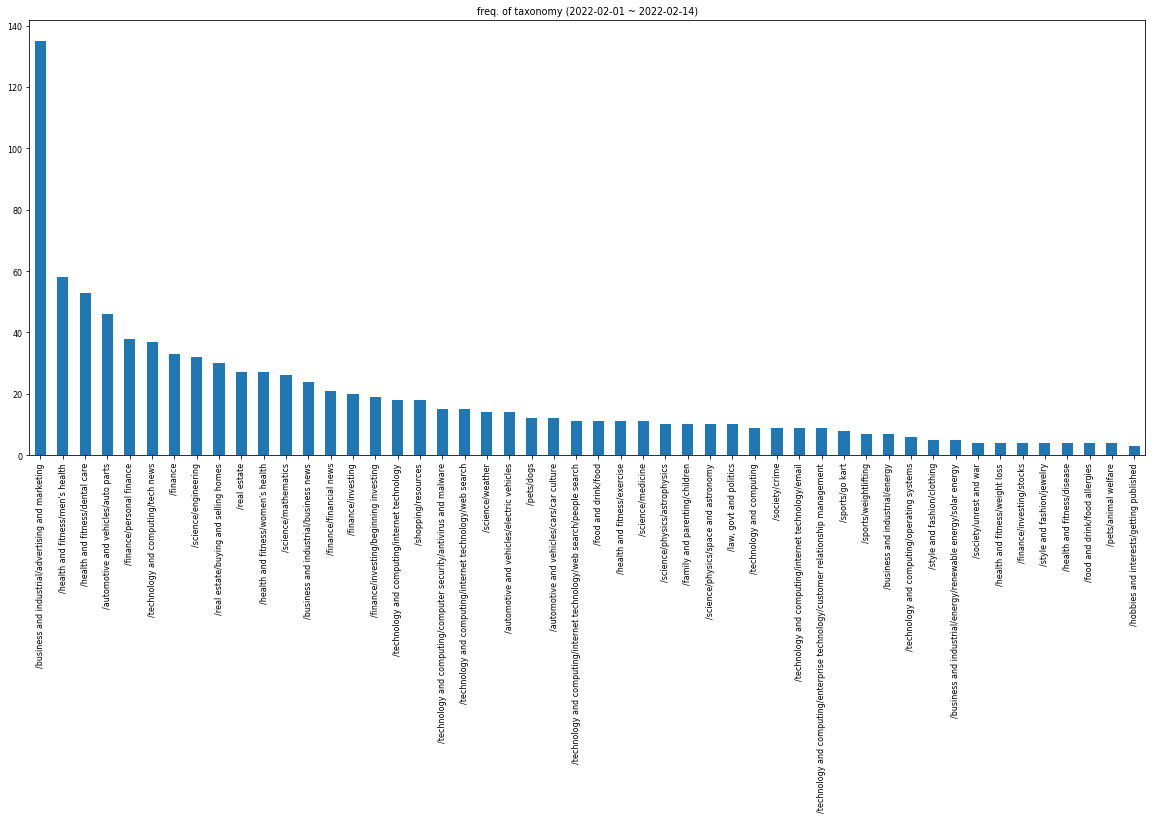

In [46]:
%matplotlib inline
bucket = ['p99', 'p95']
df_0213_p99_msn = df_0213_msn[df_0213_msn.percentile.isin(bucket)]

plt.rcParams.update({'font.size': 8})

df_0213_p99_msn['taxonomy'].value_counts()[:50].plot(kind = 'bar', figsize=(20,8), title='freq. of taxonomy (2022-02-01 ~ 2022-02-14)')

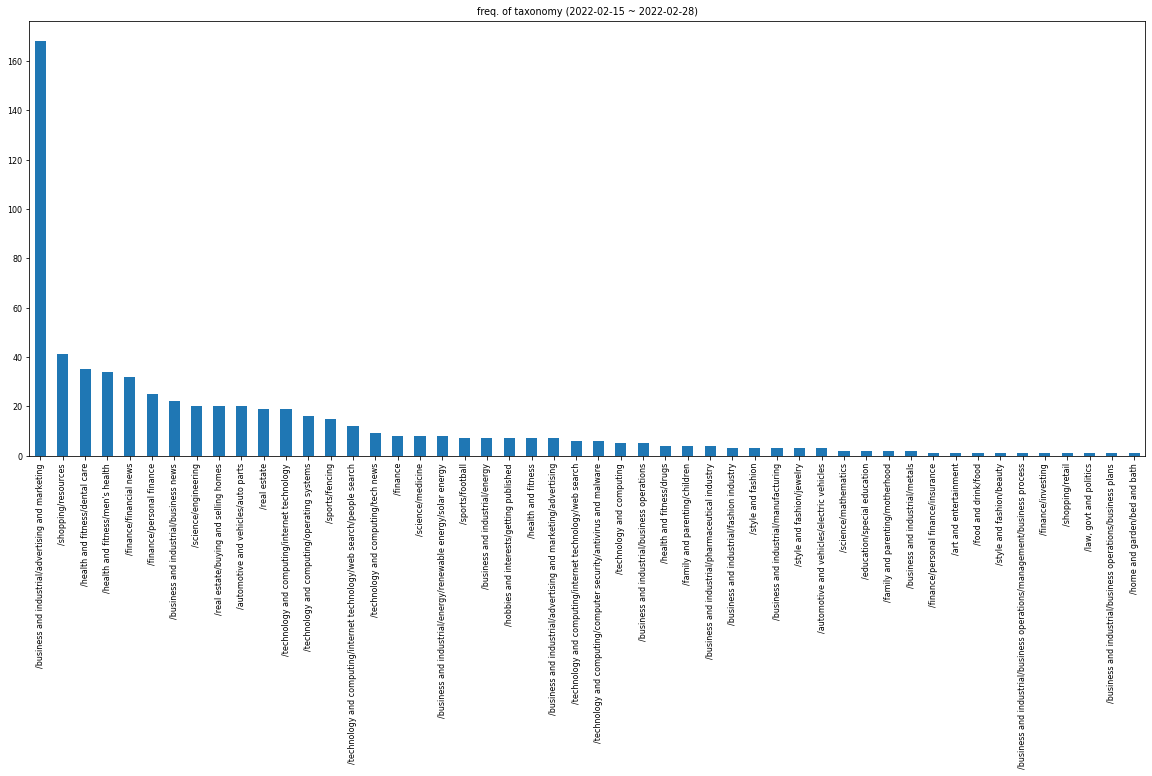

In [48]:
%matplotlib inline
bucket = ['p99','p95']
df_0228_p99_msn = df_0228_msn[df_0228_msn.percentile.isin(bucket)]

plt.rcParams.update({'font.size': 8})

df_0228_p99_msn['taxonomy'].value_counts()[:50].plot(kind = 'bar', figsize=(20,8), title='freq. of taxonomy (2022-02-15 ~ 2022-02-28)')

# Normalize revenue into percentile

In [33]:
import ast
import numpy

def normalize_revenue(revenue_lists):
    p_50 = numpy.percentile(revenue_lists, 50)
    p_75 = numpy.percentile(revenue_lists, 75)
    p_95 = numpy.percentile(revenue_lists, 95)
    p_99 = numpy.percentile(revenue_lists, 99)
    percentile_bucket = []
    for revenue in revenue_lists:
        if revenue > p_99:
            percentile_bucket.append('p99')
        elif revenue <= p_99 and revenue > p_95:
            percentile_bucket.append('p95')
        elif revenue <= p_95 and revenue > p_75:
            percentile_bucket.append('p75')
        elif revenue <= p_75 and revenue > p_50:
            percentile_bucket.append('p50')
        else:
            percentile_bucket.append('low')
    return percentile_bucket
            


In [78]:
from scipy.stats.stats import pearsonr  

revenue_list = df['revenue'].to_list()
ctr_list = df['ctr'].to_list()

In [79]:
ctr_float_list = [float(ctr) for ctr in ctr_list]

correlation, p_value = pearsonr(revenue_list, ctr_float_list)
print(correlation, p_value)

-0.01329398889923718 0.0


In [80]:
def normalize_to_two_level(category, level=2):
    cat_lists = category.split("/")
    new_category = ""
    for i in range(1, min(level, len(cat_lists))):
        #print(i, cat_lists[i])
        if i <= min(level, len(cat_lists))-1:
            new_category+=cat_lists[i]
        else:
            new_category+=cat_lists[i]+"/"
    return new_category

print(normalize_to_two_level("/art and entertainment/music"))

art and entertainment


In [81]:
taxonomy_option0 = []
taxonomy_option1 = []
taxonomy_option2 = []

taxonomy_list = df['taxonomy'].to_list()
for taxonomies in taxonomy_list:
    #print(taxonomies)
    try:
        if "law, govt and politics" in taxonomies:
            taxonomies = taxonomies.replace("law, govt and politics", "law. govt and politics")
        taxonomy_lists = taxonomies.split(",")
        if "law. govt and politics" in taxonomy_lists[0]:
            taxonomy_option0.append(normalize_to_two_level(taxonomy_lists[0].replace("law. govt and politics", "law, govt and politics")))
        else:
            taxonomy_option0.append(normalize_to_two_level(taxonomy_lists[0]))
    except TypeError as te:
        print(taxonomies)


In [17]:
df['label'] = taxonomy_option0

# Distribution over percentile

In [150]:
#df_0223 = df[(df['Date']>datetime.date(2022,2,6)) & (df['Date']<datetime.date(2022,2,24))]
revenue_lists = df_A['revenue'].tolist()
percentile_bucket = normalize_revenue(revenue_lists)
df_A['percentile'] = percentile_bucket
df_A

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,item_hash,publisher_id,campaign_type,title,item_type,impressions,clicks,ctr,revenue,calibrated_clicks,calibrated_revenue,received_timestamp,taxonomy,Date,percentile
3,7792233817584357870,1076408,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,9,1,0.111111111111111111,0.134623,1,0.134623,2022-02-14 20:00:12,/business and industrial/company,2022-02-14,p50
8,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,128,0,0,0.000000,0,0.000000,2022-02-10 20:00:21,/business and industrial/company,2022-02-10,low
11,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,111,0,0,0.000000,0,0.000000,2022-02-08 20:00:26,/business and industrial/company,2022-02-08,low
12,7792233817584357870,1076408,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,47,1,0.021276595744680851,0.148085,1,0.148085,2022-02-06 20:00:33,/business and industrial/company,2022-02-06,p50
17,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,145,0,0,0.000000,0,0.000000,2022-02-09 20:00:24,/business and industrial/company,2022-02-09,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267285,543095233795352465,1038711,SPONSORED,7 Signs of Tinnitus You Should Not Ignore,Video,123,0,0,0.000000,0,0.000000,2022-02-09 20:00:24,/health and fitness/disease/deafness,2022-02-09,low
20267286,543095233795352465,1038711,SPONSORED,7 Signs of Tinnitus You Should Not Ignore,Video,116,0,0,0.000000,0,0.000000,2022-02-06 20:00:33,/health and fitness/disease/deafness,2022-02-06,low
20267288,543095233795352465,1247031,SPONSORED,7 Signs of Tinnitus You Should Not Ignore,Video,23,1,0.043478260869565217,0.010000,1,0.010000,2022-02-08 20:00:26,/health and fitness/disease/deafness,2022-02-08,p50
20267292,543095233795352465,1038711,SPONSORED,7 Signs of Tinnitus You Should Not Ignore,Video,137,0,0,0.000000,0,0.000000,2022-02-11 20:00:28,/health and fitness/disease/deafness,2022-02-11,low


In [151]:
#df_0309 = df[(df['Date']>datetime.date(2022,2,23)) & (df['Date']<datetime.date(2022,3,9))]
revenue_lists = df_B['revenue'].tolist()
percentile_bucket = normalize_revenue(revenue_lists)
df_B['percentile'] = percentile_bucket
df_B

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,item_hash,publisher_id,campaign_type,title,item_type,impressions,clicks,ctr,revenue,calibrated_clicks,calibrated_revenue,received_timestamp,taxonomy,Date,percentile
0,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,177,0,0,0.000000,0,0.000000,2022-02-15 20:00:36,/business and industrial/company,2022-02-15,low
1,7792233817584357870,1076408,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,26,1,0.038461538461538462,0.158574,1,0.158574,2022-02-23 20:00:27,/business and industrial/company,2022-02-23,p50
2,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,121,0,0,0.000000,0,0.000000,2022-02-24 20:01:08,/business and industrial/company,2022-02-24,low
6,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,120,0,0,0.000000,0,0.000000,2022-02-23 20:00:27,/business and industrial/company,2022-02-23,low
7,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,144,0,0,0.000000,0,0.000000,2022-02-17 20:00:46,/business and industrial/company,2022-02-17,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267290,543095233795352465,1038711,SPONSORED,7 Signs of Tinnitus You Should Not Ignore,Video,131,0,0,0.000000,0,0.000000,2022-02-25 20:01:02,/health and fitness/disease/deafness,2022-02-25,low
20267291,543095233795352465,1038711,SPONSORED,7 Signs of Tinnitus You Should Not Ignore,Video,116,0,0,0.000000,0,0.000000,2022-02-17 20:00:46,/health and fitness/disease/deafness,2022-02-17,low
20267296,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,691,4,0.005788712011577424,0.269330,4,0.269330,2022-02-27 20:01:14,/health and fitness/disease/deafness,2022-02-27,p75
20267299,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,529,3,0.005671077504725898,0.201998,3,0.201998,2022-02-26 20:00:51,/health and fitness/disease/deafness,2022-02-26,p50


In [152]:
revenue_lists = df_C['revenue'].tolist()
percentile_bucket = normalize_revenue(revenue_lists)
df_C['percentile'] = percentile_bucket
df_C

/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,item_hash,publisher_id,campaign_type,title,item_type,impressions,clicks,ctr,revenue,calibrated_clicks,calibrated_revenue,received_timestamp,taxonomy,Date,percentile
4,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,129,0,0,0.000000,0,0.000000,2022-03-07 20:00:16,/business and industrial/company,2022-03-07,low
5,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,119,0,0,0.000000,0,0.000000,2022-03-06 20:00:19,/business and industrial/company,2022-03-06,low
15,7792233817584357870,1010748,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,113,0,0,0.000000,0,0.000000,2022-03-01 20:01:25,/business and industrial/company,2022-03-01,low
20,7792233817584357870,1187,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,189,0,0,0.000000,0,0.000000,2022-03-01 20:01:25,/business and industrial/company,2022-03-01,low
31,7792233817584357870,1076408,SPONSORED,恨まれながらも社員を全員解雇、事業承継した3代目の改革への想い,Video,20,1,0.050000000000000000,0.157622,1,0.157622,2022-03-07 20:00:16,/business and industrial/company,2022-03-07,p50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267303,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,279,1,0.003584229390681004,0.065457,1,0.065457,2022-03-11 20:01:09,/health and fitness/disease/deafness,2022-03-11,p50
20267304,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,396,3,0.007575757575757576,0.199591,3,0.199591,2022-03-08 20:00:40,/health and fitness/disease/deafness,2022-03-08,p50
20267305,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,749,6,0.008010680907877170,0.395792,6,0.395792,2022-03-10 20:00:49,/health and fitness/disease/deafness,2022-03-10,p75
20267306,3737046637229653121,1399530,SPONSORED,Tinnitus? Wenn das Klingeln nicht aufhört - Tu...,Video,190,2,0.010526315789473684,0.144850,2,0.144850,2022-03-06 20:00:19,/health and fitness/disease/deafness,2022-03-06,p50


# Taxonomy difference before and after war

In [164]:
df_A_taxonomy_revenue = df_A.groupby(['taxonomy'])['revenue'].sum().reset_index()
df_A_taxonomy_revenue

,taxonomy,revenue
0,/art and entertainment,50846.053982
1,/art and entertainment/books and literature,55935.988422
2,/art and entertainment/books and literature/ch...,0.048000
3,/art and entertainment/books and literature/e-...,1.165560
4,/art and entertainment/books and literature/fa...,62.175584
...,...,...
847,/travel/transports/train travel,23.713386
848,/travel/travel agencies,1.000000
849,/travel/travel guides,57.055932
850,/travel/traveling with kids,6408.291960


In [165]:
df_B_taxonomy_revenue = df_B.groupby(['taxonomy'])['revenue'].sum().reset_index()
df_B_taxonomy_revenue

,taxonomy,revenue
0,/art and entertainment,49206.730302
1,/art and entertainment/books and literature,47464.835070
2,/art and entertainment/books and literature/e-...,22.272840
3,/art and entertainment/books and literature/fa...,5.579192
4,/art and entertainment/books and literature/my...,119.203120
...,...,...
831,/travel/transports/train travel,20.527569
832,/travel/travel agencies,3.000000
833,/travel/travel guides,106.365278
834,/travel/traveling with kids,17821.778115


In [166]:
df_C_taxonomy_revenue = df_C.groupby(['taxonomy'])['revenue'].sum().reset_index()
df_C_taxonomy_revenue

,taxonomy,revenue
0,/art and entertainment,42067.293059
1,/art and entertainment/books and literature,24500.138131
2,/art and entertainment/books and literature/e-...,11.409098
3,/art and entertainment/books and literature/fa...,5.084166
4,/art and entertainment/books and literature/my...,1.855345
...,...,...
827,/travel/transports/train travel,15.989755
828,/travel/travel agencies,2.000000
829,/travel/travel guides,43.149914
830,/travel/traveling with kids,22562.914163


In [167]:
df_A_taxonomy_click = df_A.groupby(['taxonomy'])['clicks'].sum().reset_index()
df_A_taxonomy_revenue['clicks'] = df_A_taxonomy_click['clicks']
df_A_taxonomy_revenue

,taxonomy,revenue,clicks
0,/art and entertainment,50846.053982,195490
1,/art and entertainment/books and literature,55935.988422,234206
2,/art and entertainment/books and literature/ch...,0.048000,1
3,/art and entertainment/books and literature/e-...,1.165560,44
4,/art and entertainment/books and literature/fa...,62.175584,737
...,...,...,...
847,/travel/transports/train travel,23.713386,1291
848,/travel/travel agencies,1.000000,1
849,/travel/travel guides,57.055932,273
850,/travel/traveling with kids,6408.291960,39284


In [168]:
df_A_taxonomy_click = df_A.groupby(['taxonomy'])['impressions'].sum().reset_index()
df_A_taxonomy_revenue['impressions'] = df_A_taxonomy_click['impressions']
df_A_taxonomy_revenue

,taxonomy,revenue,clicks,impressions
0,/art and entertainment,50846.053982,195490,125670296
1,/art and entertainment/books and literature,55935.988422,234206,120092933
2,/art and entertainment/books and literature/ch...,0.048000,1,1
3,/art and entertainment/books and literature/e-...,1.165560,44,2706
4,/art and entertainment/books and literature/fa...,62.175584,737,676153
...,...,...,...,...
847,/travel/transports/train travel,23.713386,1291,406176
848,/travel/travel agencies,1.000000,1,17443
849,/travel/travel guides,57.055932,273,49712
850,/travel/traveling with kids,6408.291960,39284,15433198


In [170]:
df_B_taxonomy_impression = df_B.groupby(['taxonomy'])['impressions'].sum().reset_index()
df_B_taxonomy_revenue['impressions'] = df_B_taxonomy_impression['impressions']
df_B_taxonomy_revenue

,taxonomy,revenue,impressions
0,/art and entertainment,49206.730302,121373413
1,/art and entertainment/books and literature,47464.835070,113651980
2,/art and entertainment/books and literature/e-...,22.272840,26376
3,/art and entertainment/books and literature/fa...,5.579192,40853
4,/art and entertainment/books and literature/my...,119.203120,224641
...,...,...,...
831,/travel/transports/train travel,20.527569,342519
832,/travel/travel agencies,3.000000,60849
833,/travel/travel guides,106.365278,166702
834,/travel/traveling with kids,17821.778115,22883042


In [171]:
df_B_taxonomy_clicks = df_B.groupby(['taxonomy'])['clicks'].sum().reset_index()
df_B_taxonomy_revenue['clicks'] = df_B_taxonomy_clicks['clicks']
df_B_taxonomy_revenue

,taxonomy,revenue,impressions,clicks
0,/art and entertainment,49206.730302,121373413,182571
1,/art and entertainment/books and literature,47464.835070,113651980,235452
2,/art and entertainment/books and literature/e-...,22.272840,26376,785
3,/art and entertainment/books and literature/fa...,5.579192,40853,74
4,/art and entertainment/books and literature/my...,119.203120,224641,112
...,...,...,...,...
831,/travel/transports/train travel,20.527569,342519,1078
832,/travel/travel agencies,3.000000,60849,3
833,/travel/travel guides,106.365278,166702,619
834,/travel/traveling with kids,17821.778115,22883042,76451


In [172]:
df_C_taxonomy_impression = df_C.groupby(['taxonomy'])['impressions'].sum().reset_index()
df_C_taxonomy_clicks = df_C.groupby(['taxonomy'])['clicks'].sum().reset_index()
df_C_taxonomy_revenue['clicks'] = df_C_taxonomy_clicks['clicks']
df_C_taxonomy_revenue['impressions'] = df_C_taxonomy_impression['impressions']
df_C_taxonomy_revenue

,taxonomy,revenue,clicks,impressions
0,/art and entertainment,42067.293059,162695,141078876
1,/art and entertainment/books and literature,24500.138131,134734,84807391
2,/art and entertainment/books and literature/e-...,11.409098,409,15356
3,/art and entertainment/books and literature/fa...,5.084166,80,76050
4,/art and entertainment/books and literature/my...,1.855345,11,135
...,...,...,...,...
827,/travel/transports/train travel,15.989755,818,298845
828,/travel/travel agencies,2.000000,2,27128
829,/travel/travel guides,43.149914,269,44402
830,/travel/traveling with kids,22562.914163,84597,38101756


In [181]:
# distinct taxonomy
taxonomy_list = df_A_taxonomy_revenue['taxonomy'].tolist()
taxonomy_list_B = df_B_taxonomy_revenue['taxonomy'].tolist()
taxonomy_list_C = df_C_taxonomy_revenue['taxonomy'].tolist()

taxonomies = set(taxonomy_list + taxonomy_list_B + taxonomy_list_C)
print(len(taxonomies))

894


In [186]:
def taxonomy_by_revenue_map(df):
    taxonmy_list = df['taxonomy'].tolist()
    revenue_list = df['revenue'].tolist()
    impression_list = df['impressions'].tolist()
    click_list = df['clicks'].tolist()
    taxonomy_map = {}
    for i in range(0, len(taxonmy_list)):
        taxonomy = taxonmy_list[i]
        revenue = revenue_list[i]
        impressions = impression_list[i]
        clicks = click_list[i]
        #print(taxonomy, revenue)
        taxonomy_map[taxonomy] = (revenue, impressions, clicks)
    return taxonomy_map

taxonomy_map_A = taxonomy_by_revenue_map(df_A_taxonomy_revenue)
taxonomy_map_B = taxonomy_by_revenue_map(df_B_taxonomy_revenue)
taxonomy_map_C = taxonomy_by_revenue_map(df_C_taxonomy_revenue)


In [192]:
taxonomies_list = list(taxonomies)
revenue_A = []
impressions_A = []
clicks_A = []
revenue_B = []
impressions_B = []
clicks_B = []
revenue_C = []
impressions_C = []
clicks_C = []

for taxonomy in taxonomies_list:
    if taxonomy in taxonomy_map_A:
        revenue, impressions, clicks = taxonomy_map_A[taxonomy]
        #print(taxonomy, revenue, impressions)
        revenue_A.append(revenue)
        impressions_A.append(impressions)
        clicks_A.append(clicks)
    else:
        revenue_A.append(0)
        impressions_A.append(0)
        clicks_A.append(0)
        
    if taxonomy in taxonomy_map_B:
        revenue, impressions, clicks = taxonomy_map_B[taxonomy]
        #print(taxonomy, revenue, impressions)
        revenue_B.append(revenue)
        impressions_B.append(impressions)
        clicks_B.append(clicks)
    else:
        revenue_B.append(0)
        impressions_B.append(0)
        clicks_B.append(0)
        
    if taxonomy in taxonomy_map_C:
        revenue, impressions, clicks = taxonomy_map_C[taxonomy]
        #print(taxonomy, revenue, impressions)
        revenue_C.append(revenue)
        impressions_C.append(impressions)
        clicks_C.append(clicks)
    else:
        revenue_C.append(0)
        impressions_C.append(0)
        clicks_C.append(0)
d = {'taxonomy': taxonomies_list, 'revenue_0214': revenue_A, 'impression_0214': impressions_A, 'clicks_0214': clicks_A,
     'revenue_0228': revenue_B, 'impression_0228': impressions_B, 'clicks_0228': clicks_B,
     'revenue_0314': revenue_C, 'impression_0314': impressions_C, 'clicks_0314': clicks_C}
df_union = pd.DataFrame(data=d)

df_union

,taxonomy,revenue_0214,impression_0214,clicks_0214,revenue_0228,impression_0228,clicks_0228,revenue_0314,impression_0314,clicks_0314
0,/finance/accounting and auditing/tax preparati...,292.734406,582143,682,28.034032,50604,176,21.656635,43501,107
1,/hobbies and interests/paranormal phenomena,0.280000,10155,68,0.000000,0,0,53.073960,163784,144
2,/science/computer science,3.925651,53561,91,1.255391,1221,8,0.372722,8306,9
3,/business and industrial/agriculture and fores...,587.452864,1183797,1795,381.541928,1250164,2071,302.905977,1206343,1842
4,/style and fashion/jewelry/earrings,24.675120,50201,292,17.897367,23979,155,1.346941,18777,28
...,...,...,...,...,...,...,...,...,...,...
889,/style and fashion/footwear,16888.885394,86736569,52822,24999.632766,126193760,78922,19975.642921,107321324,58934
890,/technology and computing/operating systems,71376.198670,468113913,168808,75565.513430,391668775,167171,70005.054342,282718138,136483
891,/sports/boxing,6725.448373,35398399,18186,7470.526465,35080122,39850,5189.770892,18857018,19408
892,/shopping/resources/loyalty programs,0.509216,4023,6,2.726322,8469,26,0.854084,2379,9


In [193]:
df_union['diff_revenue'] = df_union['revenue_0314'] - df_union['revenue_0214']
df_union['diff_impressions'] = df_union['impression_0314'] - df_union['impression_0214']

In [194]:
df_union.sort_values(by=['diff_revenue', 'diff_impressions'], inplace=True, ascending=[True, False])
df_union

,taxonomy,revenue_0214,impression_0214,clicks_0214,revenue_0228,impression_0228,clicks_0228,revenue_0314,impression_0314,clicks_0314,diff_revenue,diff_impressions
457,/health and fitness/disease,157372.452555,564046161,631420,116486.092237,408426037,430349,92514.373271,324111153,312945,-64858.079284,-239935008
788,/finance,122301.888644,284547579,242439,92401.967524,231054628,175758,61225.526003,175423166,114232,-61076.362642,-109124413
724,/health and fitness/nutrition,107086.202829,309239664,234842,65097.425369,171134586,152674,48245.652995,130507116,118895,-58840.549834,-178732548
850,/business and industrial/advertising and marke...,249865.903984,651434525,848151,286528.384658,684755829,850729,192788.445980,609653699,611672,-57077.458005,-41780826
258,/health and fitness/men's health,167230.369682,292221196,369140,151344.706965,276054978,320671,110263.099660,260627850,267901,-56967.270022,-31593346
...,...,...,...,...,...,...,...,...,...,...,...,...
732,/real estate/architects,4008.593684,39853242,31817,16763.870159,64143192,70431,11593.398285,56150962,45442,7584.804601,16297720
839,/health and fitness,47641.275288,264036179,223201,49553.781552,230078351,212014,56150.560674,223177171,187252,8509.285385,-40859008
470,/travel/vacation rentals,5299.470797,13089162,23567,14133.836301,16582382,43432,20474.972177,30775760,56828,15175.501380,17686598
694,/sports/football,15840.610544,81517129,90608,13486.523597,58262085,55501,31546.104535,137009970,92448,15705.493991,55492841


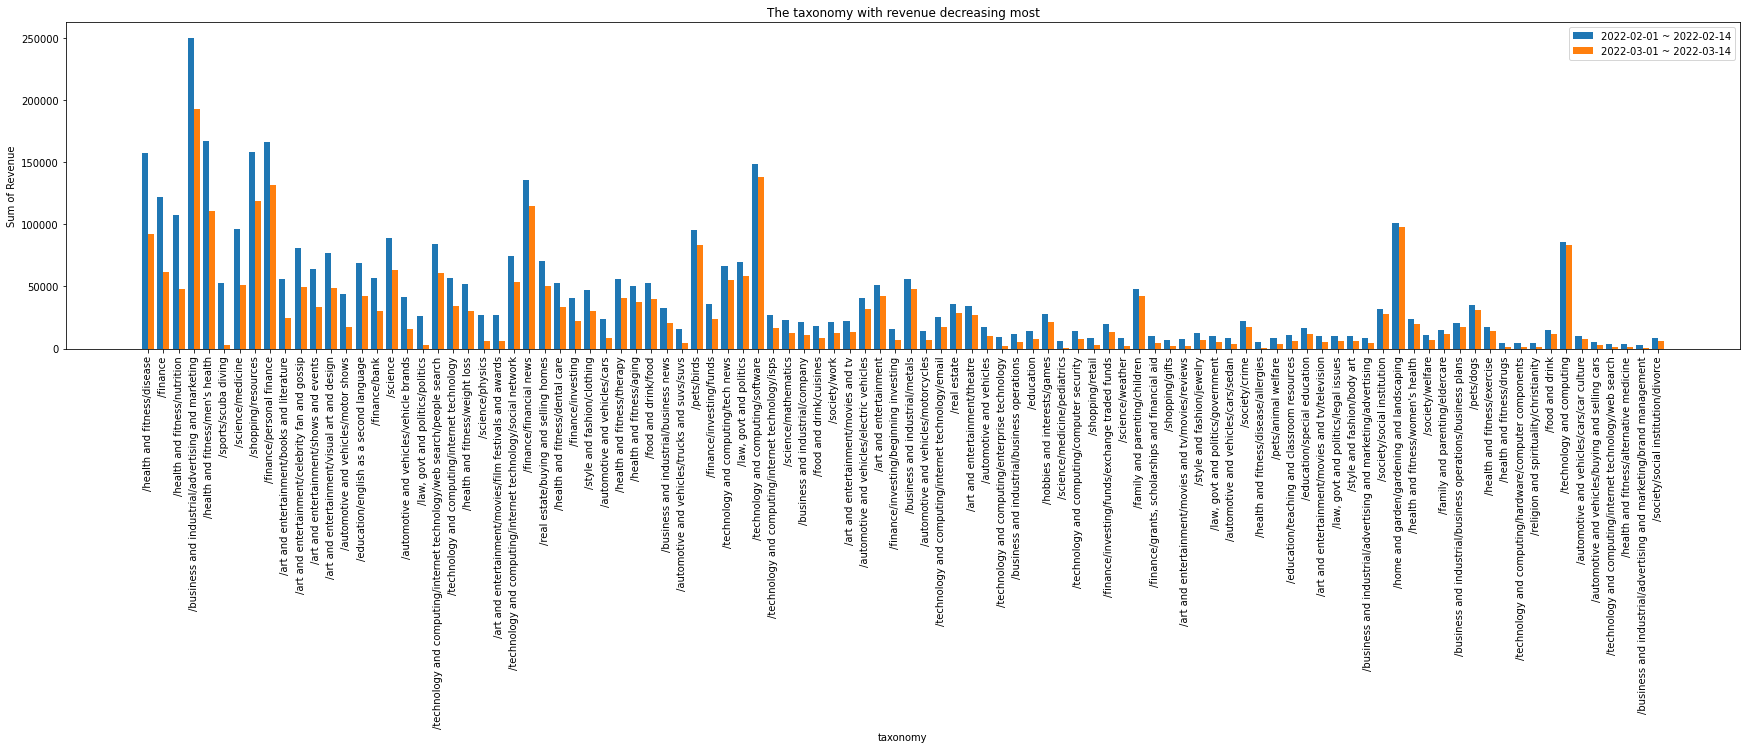

In [195]:
import numpy as np 
import matplotlib.pyplot as plt 

label1 = '2022-02-01 ~ 2022-02-14'
label2 = '2022-03-01 ~ 2022-03-14'

X_axis = np.arange(len(df_union['taxonomy'][:100]))
plt.figure(figsize=(30,6))
plt.bar(X_axis - 0.2, df_union['revenue_0214'][:100], 0.4, label = label1)
plt.bar(X_axis + 0.2, df_union['revenue_0314'][:100], 0.4, label = label2)

plt.xticks(X_axis, df_union['taxonomy'], rotation=90)
plt.xlabel("taxonomy")
plt.ylabel("Sum of Revenue")
plt.title("The taxonomy with revenue decreasing most")

plt.legend()
plt.rcParams.update({'font.size': 10})

In [196]:
df_union.sort_values(by=['diff_revenue', 'diff_impressions'], inplace=True, ascending=[False, True])
df_union

,taxonomy,revenue_0214,impression_0214,clicks_0214,revenue_0228,impression_0228,clicks_0228,revenue_0314,impression_0314,clicks_0314,diff_revenue,diff_impressions
221,/travel/traveling with kids,6408.291960,15433198,39284,17821.778115,22883042,76451,22562.914163,38101756,84597,16154.622203,22668558
694,/sports/football,15840.610544,81517129,90608,13486.523597,58262085,55501,31546.104535,137009970,92448,15705.493991,55492841
470,/travel/vacation rentals,5299.470797,13089162,23567,14133.836301,16582382,43432,20474.972177,30775760,56828,15175.501380,17686598
839,/health and fitness,47641.275288,264036179,223201,49553.781552,230078351,212014,56150.560674,223177171,187252,8509.285385,-40859008
732,/real estate/architects,4008.593684,39853242,31817,16763.870159,64143192,70431,11593.398285,56150962,45442,7584.804601,16297720
...,...,...,...,...,...,...,...,...,...,...,...,...
258,/health and fitness/men's health,167230.369682,292221196,369140,151344.706965,276054978,320671,110263.099660,260627850,267901,-56967.270022,-31593346
850,/business and industrial/advertising and marke...,249865.903984,651434525,848151,286528.384658,684755829,850729,192788.445980,609653699,611672,-57077.458005,-41780826
724,/health and fitness/nutrition,107086.202829,309239664,234842,65097.425369,171134586,152674,48245.652995,130507116,118895,-58840.549834,-178732548
788,/finance,122301.888644,284547579,242439,92401.967524,231054628,175758,61225.526003,175423166,114232,-61076.362642,-109124413


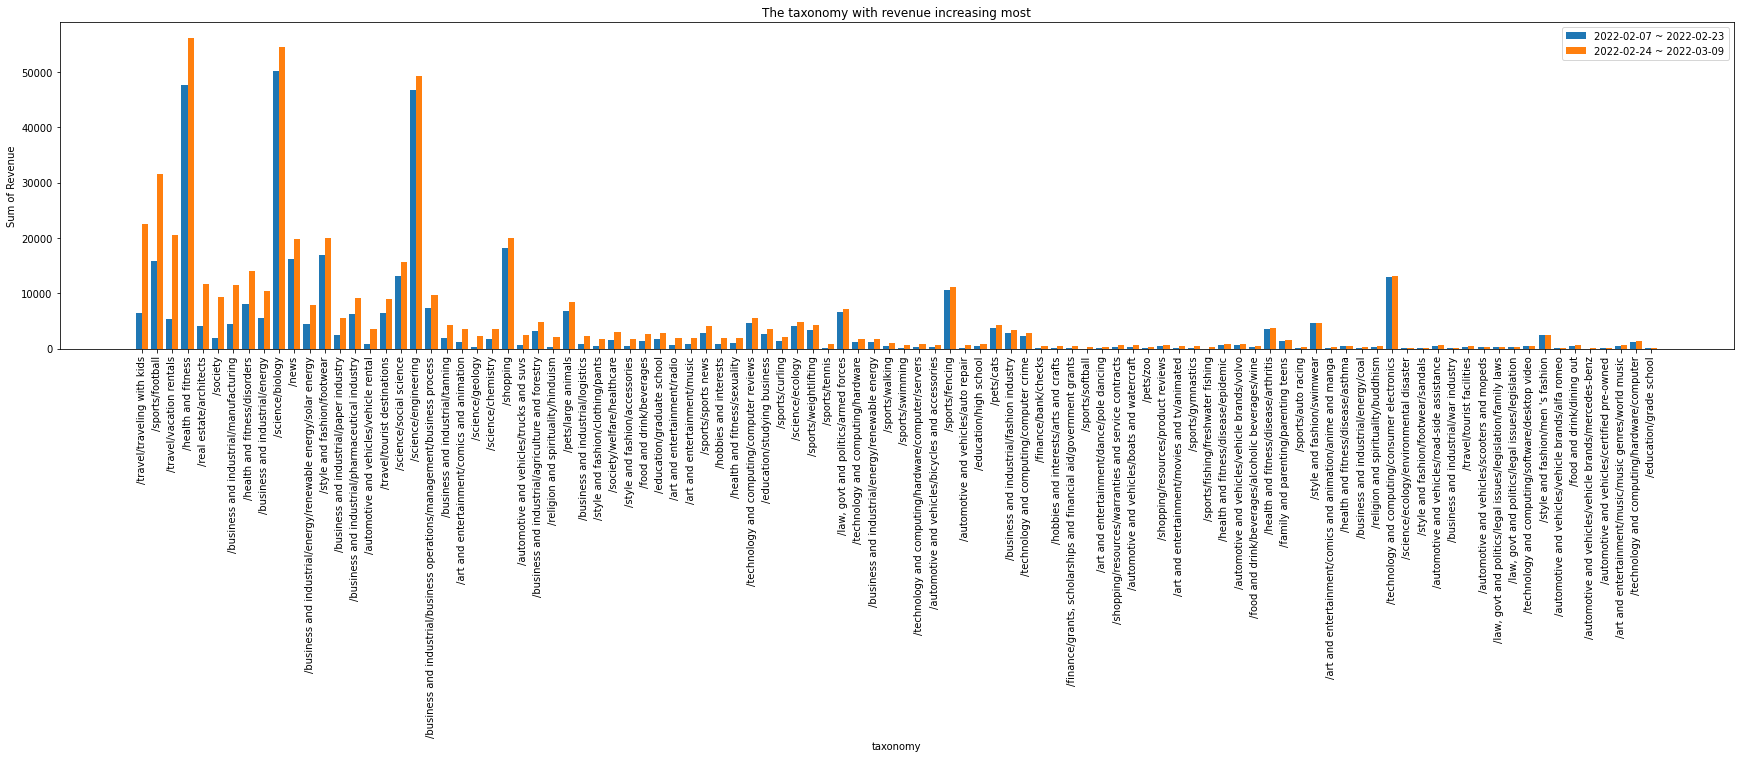

In [197]:
import numpy as np 
import matplotlib.pyplot as plt 

label1 = '2022-02-01 ~ 2022-02-14'
label2 = '2022-03-01 ~ 2022-03-14'

X_axis = np.arange(len(df_union['taxonomy'][:100]))
plt.figure(figsize=(30,6))
plt.bar(X_axis - 0.2, df_union['revenue_0214'][:100], 0.4, label = label1)
plt.bar(X_axis + 0.2, df_union['revenue_0314'][:100], 0.4, label = label2)

plt.xticks(X_axis, df_union['taxonomy'], rotation=90)
plt.xlabel("taxonomy")
plt.ylabel("Sum of Revenue")
plt.title("The taxonomy with revenue increasing most")

plt.legend()
plt.rcParams.update({'font.size': 10})

In [198]:
df_union.sort_values(by=['diff_impressions'], inplace=True, ascending=[False])
df_union

,taxonomy,revenue_0214,impression_0214,clicks_0214,revenue_0228,impression_0228,clicks_0228,revenue_0314,impression_0314,clicks_0314,diff_revenue,diff_impressions
652,/technology and computing,85838.342710,265013626,222279,102534.818547,328520352,228732,83096.311902,322398281,192085,-2742.030807,57384655
694,/sports/football,15840.610544,81517129,90608,13486.523597,58262085,55501,31546.104535,137009970,92448,15705.493991,55492841
183,/society/work,21713.154774,75095331,62560,19226.958908,82585906,67724,12135.298418,115807189,69177,-9577.856356,40711858
841,/business and industrial/manufacturing,4431.263864,14544053,18491,17640.639144,51227673,65690,11462.944747,54388973,39396,7031.680883,39844920
123,/business and industrial/energy,5557.492382,21697697,26379,11010.449655,53464844,46731,10443.847143,47694456,38341,4886.354761,25996759
...,...,...,...,...,...,...,...,...,...,...,...,...
600,/automotive and vehicles/motor shows,44213.845185,215087840,175365,46098.296337,207149919,188873,17588.205912,78740169,66855,-26625.639273,-136347671
724,/health and fitness/nutrition,107086.202829,309239664,234842,65097.425369,171134586,152674,48245.652995,130507116,118895,-58840.549834,-178732548
890,/technology and computing/operating systems,71376.198670,468113913,168808,75565.513430,391668775,167171,70005.054342,282718138,136483,-1371.144327,-185395775
805,/sports/fencing,10666.247902,271549027,47704,10564.515164,133301607,33459,11142.481251,54435572,22581,476.233349,-217113455


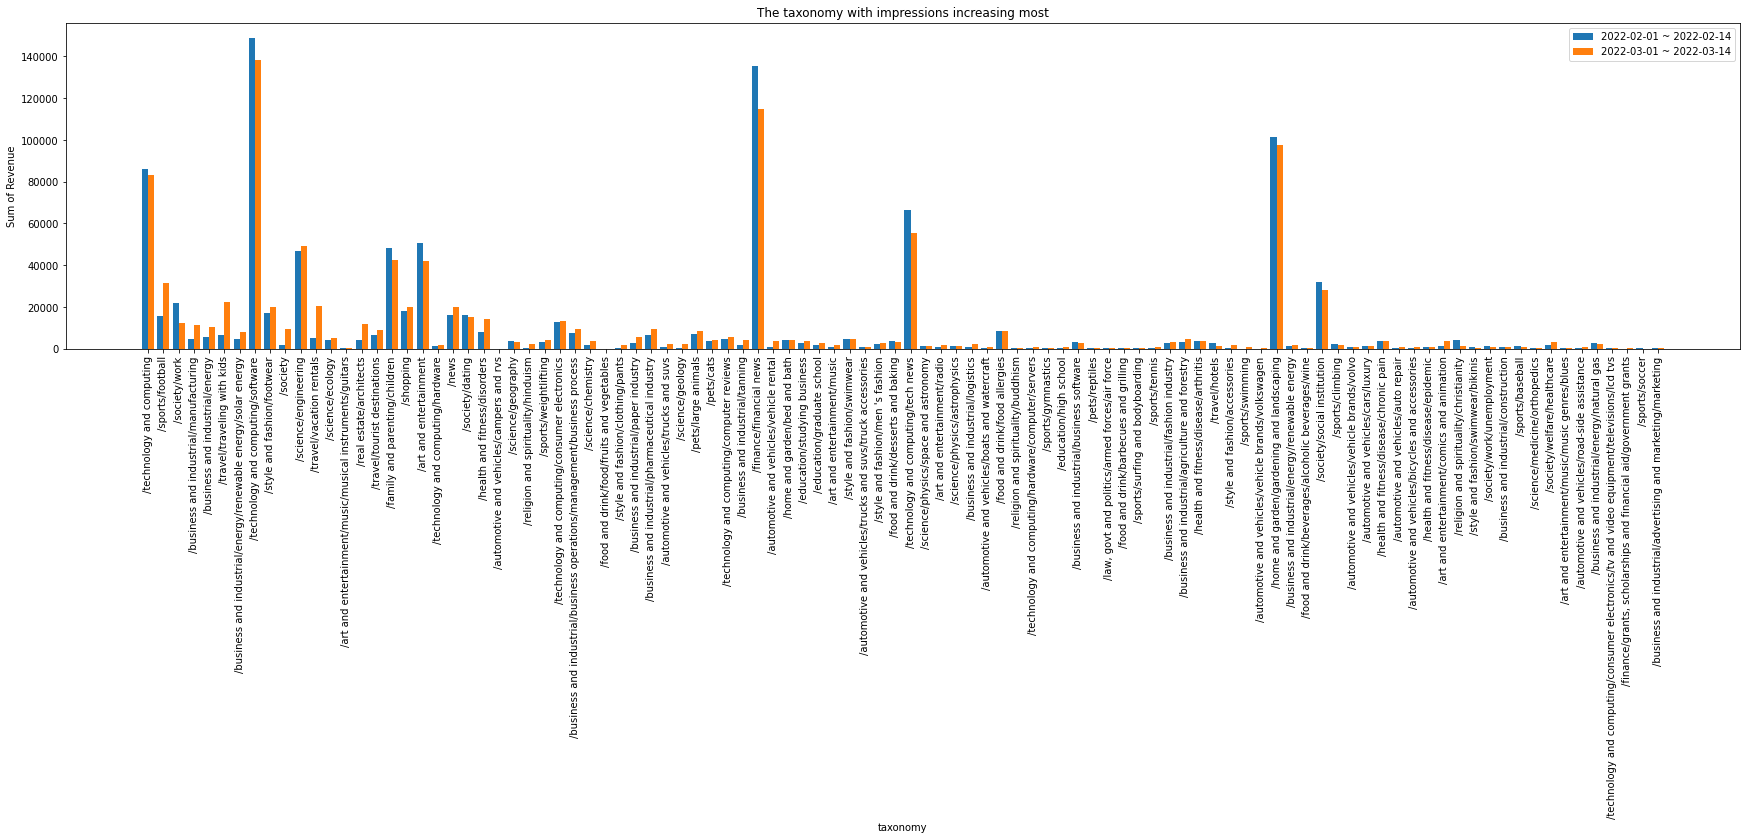

In [199]:
import numpy as np 
import matplotlib.pyplot as plt 

label1 = '2022-02-01 ~ 2022-02-14'
label2 = '2022-03-01 ~ 2022-03-14'

X_axis = np.arange(len(df_union['taxonomy'][:100]))
plt.figure(figsize=(30,6))
plt.bar(X_axis - 0.2, df_union['revenue_0214'][:100], 0.4, label = label1)
plt.bar(X_axis + 0.2, df_union['revenue_0314'][:100], 0.4, label = label2)

plt.xticks(X_axis, df_union['taxonomy'], rotation=90)
plt.xlabel("taxonomy")
plt.ylabel("Sum of Revenue")
plt.title("The taxonomy with impressions increasing most")

plt.legend()
plt.rcParams.update({'font.size': 10})

In [200]:
df_union.sort_values(by=['diff_impressions'], inplace=True, ascending=[True])
df_union

,taxonomy,revenue_0214,impression_0214,clicks_0214,revenue_0228,impression_0228,clicks_0228,revenue_0314,impression_0314,clicks_0314,diff_revenue,diff_impressions
457,/health and fitness/disease,157372.452555,564046161,631420,116486.092237,408426037,430349,92514.373271,324111153,312945,-64858.079284,-239935008
805,/sports/fencing,10666.247902,271549027,47704,10564.515164,133301607,33459,11142.481251,54435572,22581,476.233349,-217113455
890,/technology and computing/operating systems,71376.198670,468113913,168808,75565.513430,391668775,167171,70005.054342,282718138,136483,-1371.144327,-185395775
724,/health and fitness/nutrition,107086.202829,309239664,234842,65097.425369,171134586,152674,48245.652995,130507116,118895,-58840.549834,-178732548
600,/automotive and vehicles/motor shows,44213.845185,215087840,175365,46098.296337,207149919,188873,17588.205912,78740169,66855,-26625.639273,-136347671
...,...,...,...,...,...,...,...,...,...,...,...,...
123,/business and industrial/energy,5557.492382,21697697,26379,11010.449655,53464844,46731,10443.847143,47694456,38341,4886.354761,25996759
841,/business and industrial/manufacturing,4431.263864,14544053,18491,17640.639144,51227673,65690,11462.944747,54388973,39396,7031.680883,39844920
183,/society/work,21713.154774,75095331,62560,19226.958908,82585906,67724,12135.298418,115807189,69177,-9577.856356,40711858
694,/sports/football,15840.610544,81517129,90608,13486.523597,58262085,55501,31546.104535,137009970,92448,15705.493991,55492841


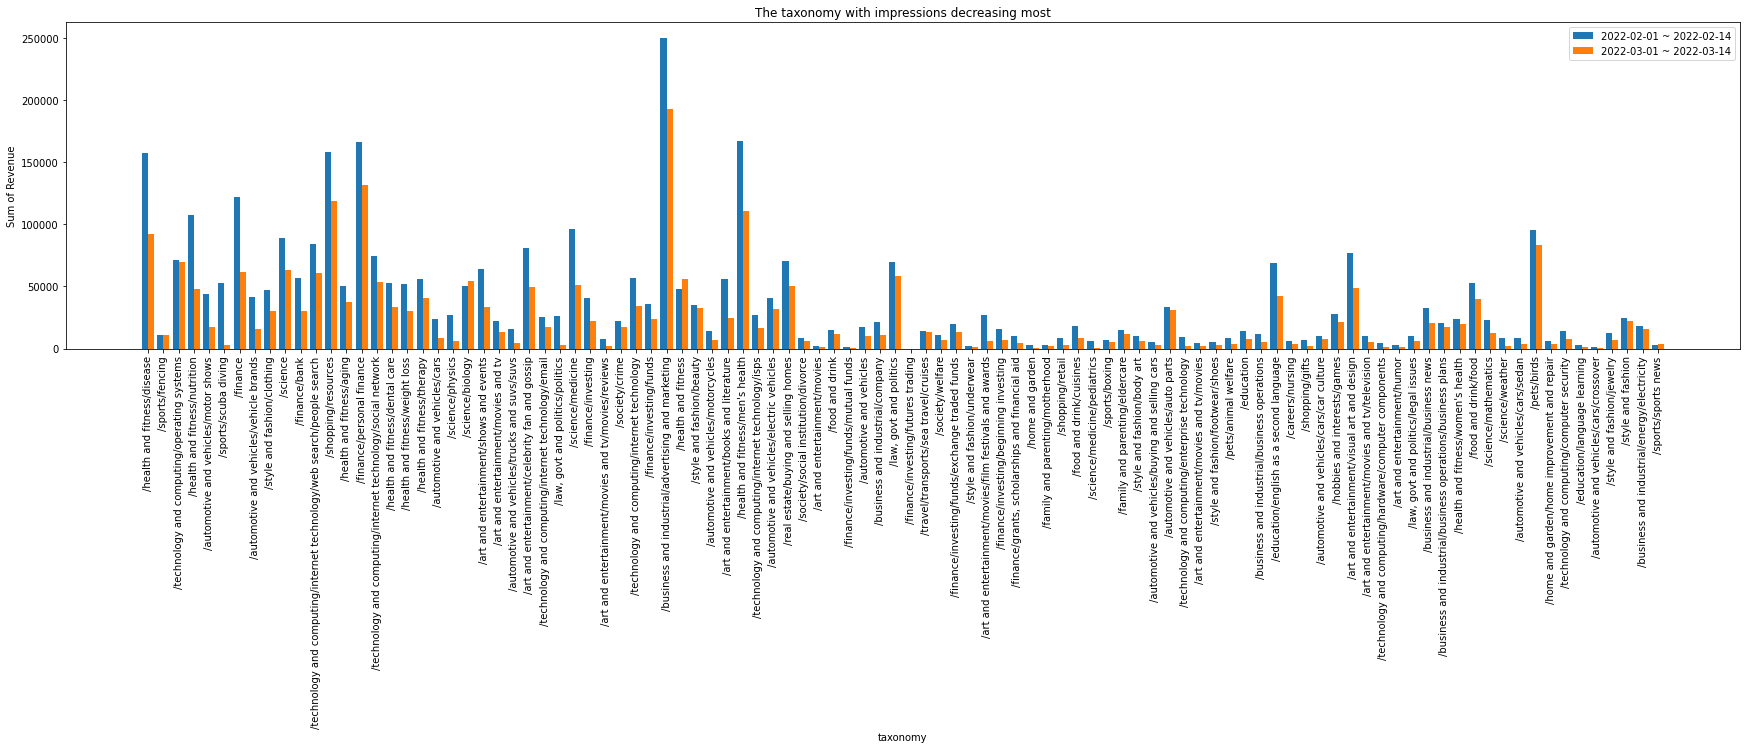

In [201]:
import numpy as np 
import matplotlib.pyplot as plt 

label1 = '2022-02-01 ~ 2022-02-14'
label2 = '2022-03-01 ~ 2022-03-14'

X_axis = np.arange(len(df_union['taxonomy'][:100]))
plt.figure(figsize=(30,6))
plt.bar(X_axis - 0.2, df_union['revenue_0214'][:100], 0.4, label = label1)
plt.bar(X_axis + 0.2, df_union['revenue_0314'][:100], 0.4, label = label2)

plt.xticks(X_axis, df_union['taxonomy'], rotation=90)
plt.xlabel("taxonomy")
plt.ylabel("Sum of Revenue")
plt.title("The taxonomy with impressions decreasing most")

plt.legend()
plt.rcParams.update({'font.size': 10})

In [202]:
import csv

df_union.to_csv('/cache/revenue.csv',sep=',',index=False, header=True, quoting=csv.QUOTE_ALL)

In [203]:
!hadoop fs -put -f /cache/revenue.csv hdfs://nr-hbase-c-hdfs.service.consul.taboolasyndication.com:8020/newsroom-backend/jupyter/notebooks/allen.wu

2022-03-16 03:07:26,258 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false


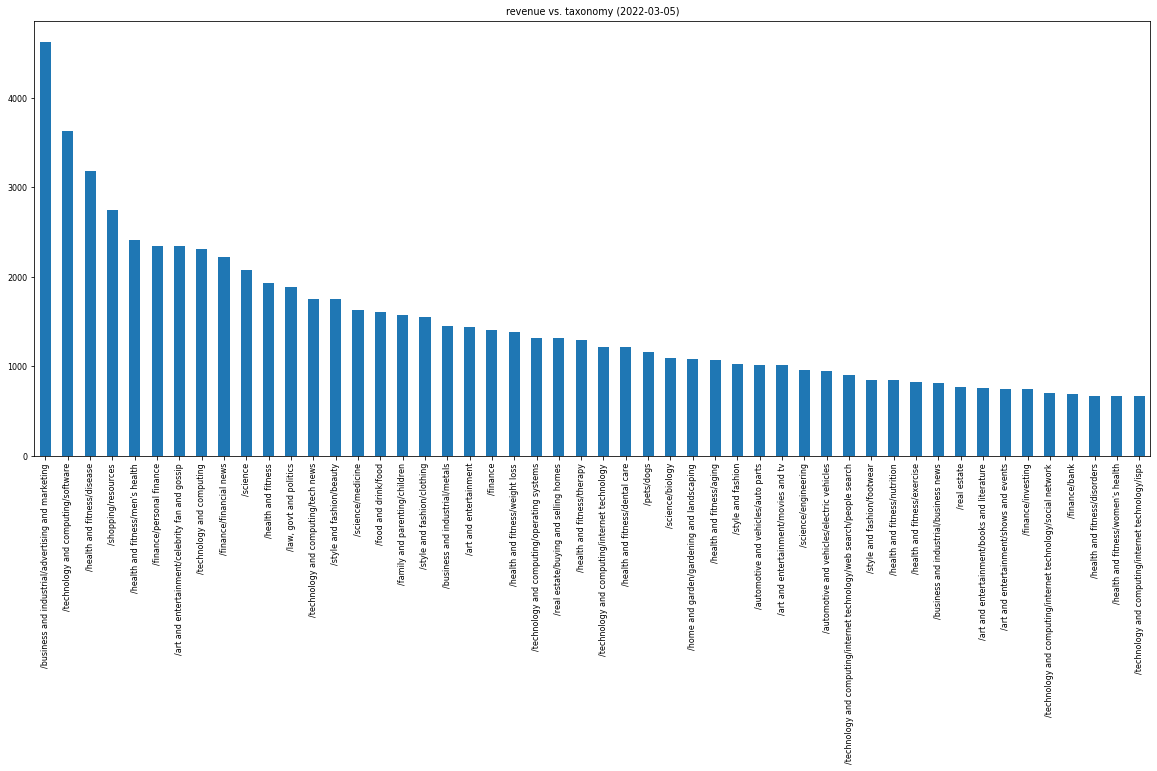

In [102]:
%matplotlib inline
dfB_p99 = df_B[df_B.percentile.isin(bucket)]

plt.rcParams.update({'font.size': 8})

dfB_p99['taxonomy'].value_counts()[:50].plot(kind = 'bar', figsize=(20,8), title='revenue vs. taxonomy (2022-03-05)')

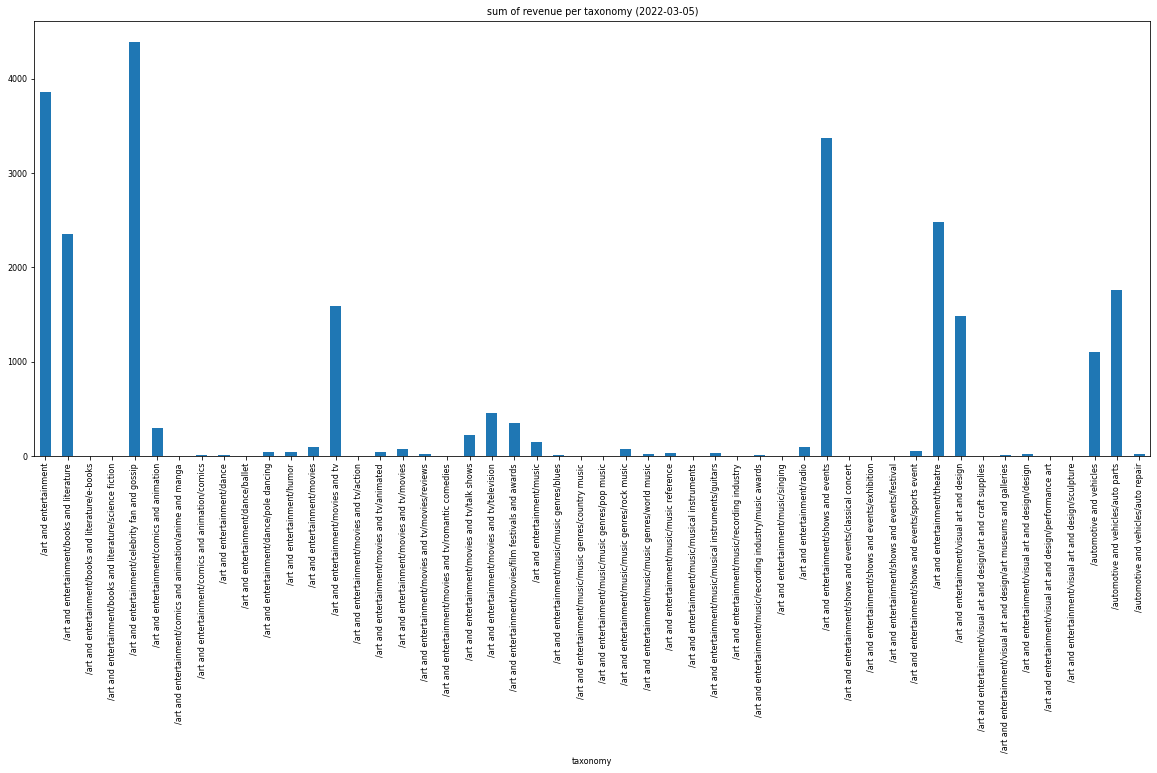

In [125]:
dfB_p99.groupby(['taxonomy'])['revenue'].sum()[:50].plot(kind = 'bar', figsize=(20,8), title='sum of revenue per taxonomy (2022-03-05)')

# ctr vs. revenue (p95)

In [40]:
bucket = ['p95']
df_ctr_p99 = df[df.ctr_percentile.isin(bucket)]

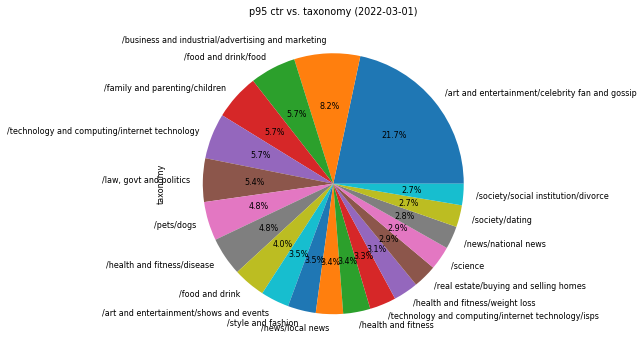

In [44]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_ctr_p99['taxonomy'].value_counts()[:50].plot(kind = 'bar', figsize=(20,8), title='p95 ctr vs. taxonomy (2022-03-01)')

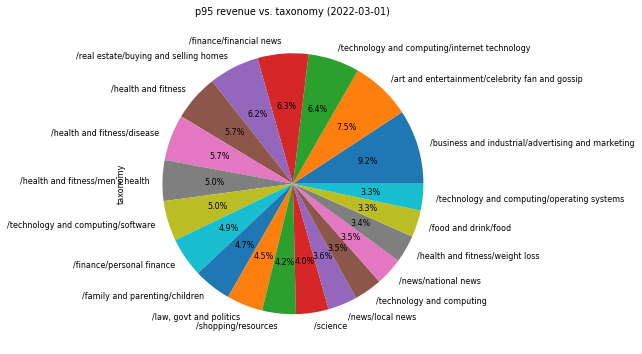

In [43]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p95['taxonomy'].value_counts()[:20].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p95 revenue vs. taxonomy (2022-03-01)')

# Distribution over taxonomy (p99)

In [21]:
bucket = ['p99']
df_p99 = df[df.percentile.isin(bucket)]

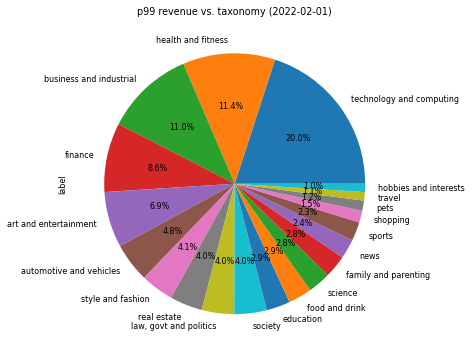

In [44]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p99['label'].value_counts()[:20].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p99 revenue vs. taxonomy (2022-02-01)')

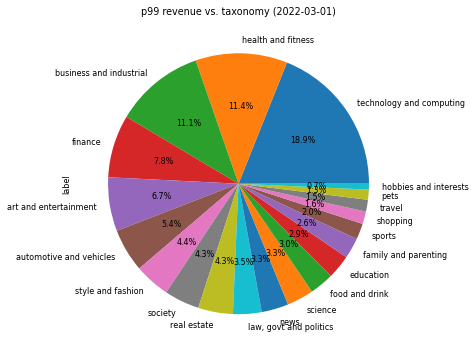

In [23]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p99['label'].value_counts()[:20].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p99 revenue vs. taxonomy (2022-03-01)')

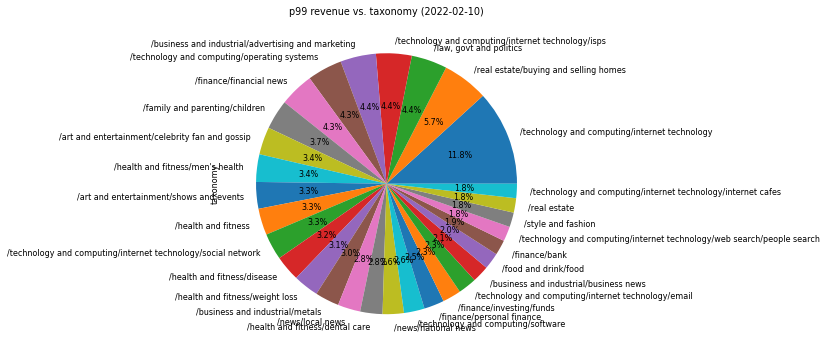

In [17]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p99['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p99 revenue vs. taxonomy (2022-02-10)')

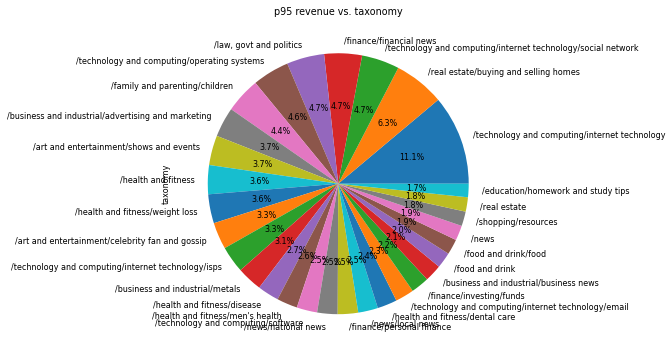

In [38]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p99['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p95 revenue vs. taxonomy') #2022-02-24

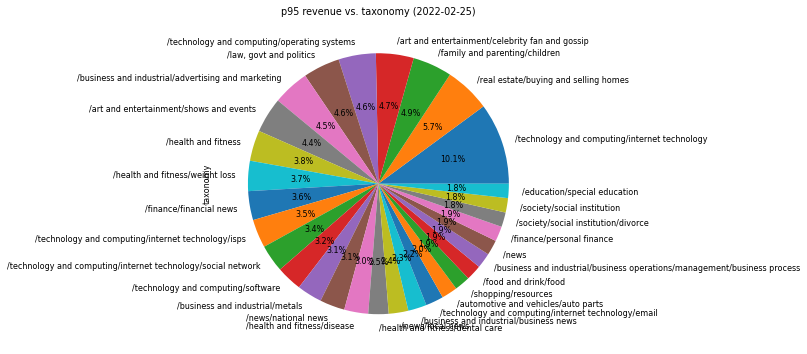

In [20]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p99['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p95 revenue vs. taxonomy (2022-02-25)')

# Distribution over taxonomy (p95)

In [24]:
bucket = ['p95']
df_p95 = df[df.percentile.isin(bucket)]

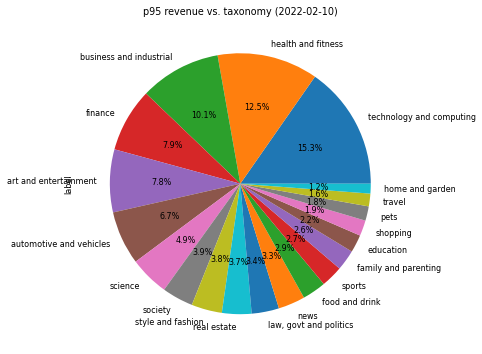

In [47]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p95['label'].value_counts()[:20].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p95 revenue vs. taxonomy (2022-02-10)')

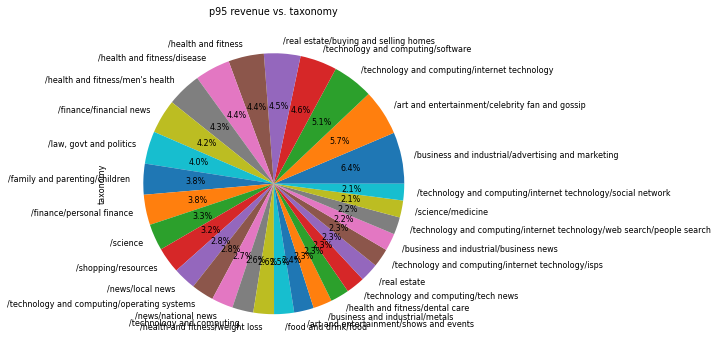

In [37]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p95['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p95 revenue vs. taxonomy')

In [18]:
bucket = ['p95']
df_p95 = df[df.percentile.isin(bucket)]

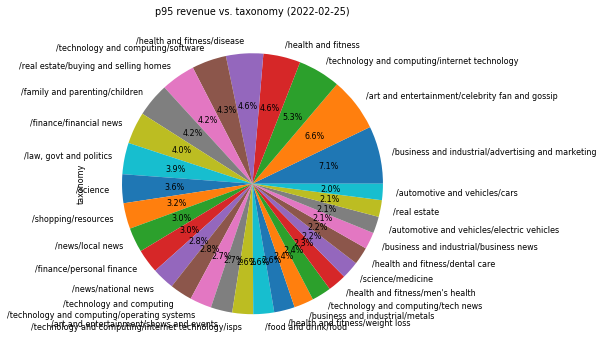

In [19]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p95['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p95 revenue vs. taxonomy (2022-02-25)')

# Distribution over taxonomy (p75)

In [26]:
bucket = ['p75']
df_p75 = df[df.percentile.isin(bucket)]

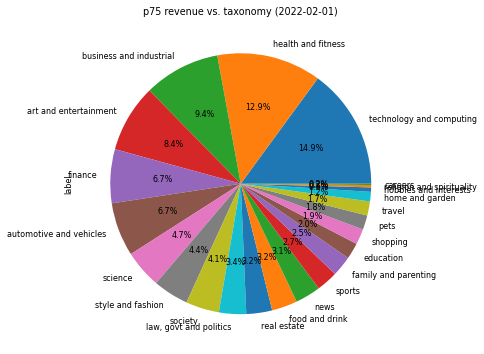

In [50]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p75['label'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p75 revenue vs. taxonomy (2022-02-01)')

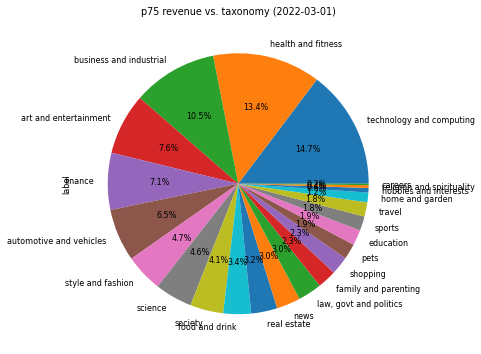

In [27]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p75['label'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p75 revenue vs. taxonomy (2022-03-01)')

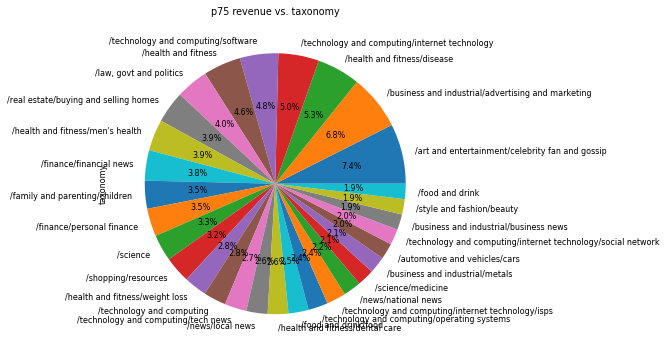

In [47]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p75['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p75 revenue vs. taxonomy')

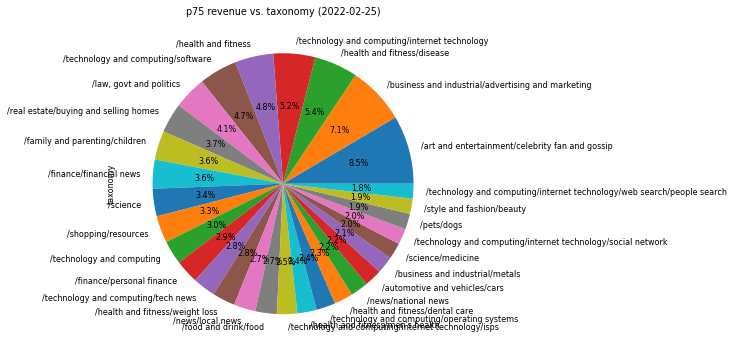

In [22]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p75['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p75 revenue vs. taxonomy (2022-02-25)')

# Distribution over taxonomy (p50)

In [28]:
bucket = ['p50']
df_p50 = df[df.percentile.isin(bucket)]

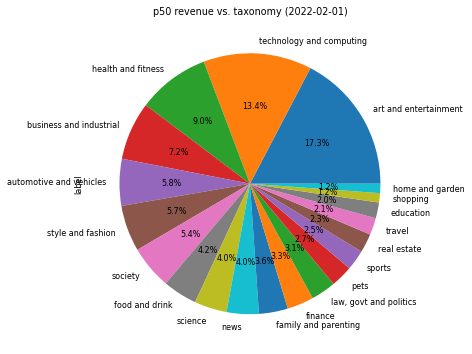

In [53]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p50['label'].value_counts()[:20].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p50 revenue vs. taxonomy (2022-02-01)')

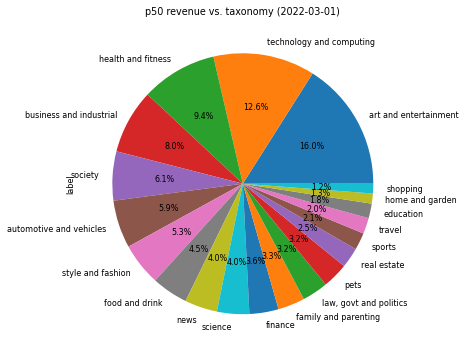

In [29]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p50['label'].value_counts()[:20].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p50 revenue vs. taxonomy (2022-03-01)')

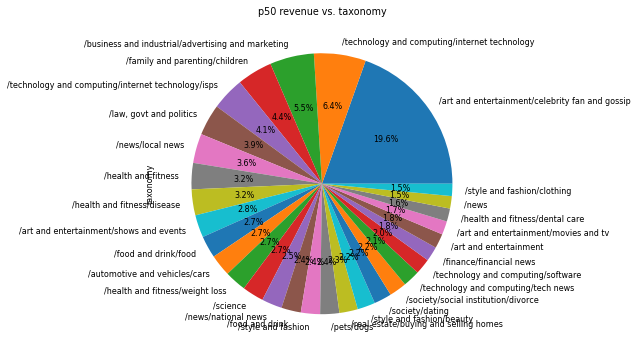

In [49]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p50['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p50 revenue vs. taxonomy')

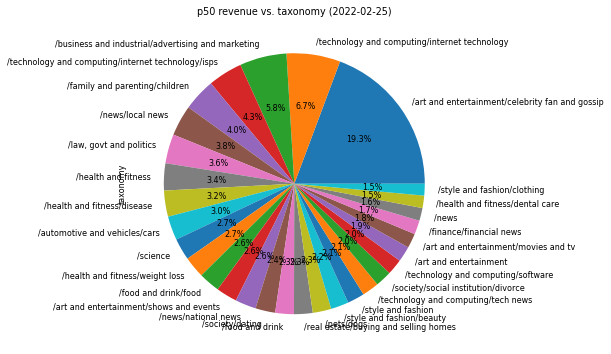

In [24]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_p50['taxonomy'].value_counts()[:30].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='p50 revenue vs. taxonomy (2022-02-25)')

# Distribution over low revenue items (03-01)

In [31]:
bucket = ['low']
df_low = df[df.percentile.isin(bucket)]

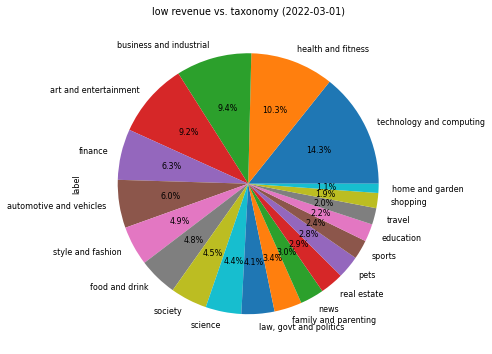

In [32]:
%matplotlib inline

plt.rcParams.update({'font.size': 8})

df_low['label'].value_counts()[:20].plot(kind = 'pie', figsize=(20,6), autopct='%1.1f%%', title='low revenue vs. taxonomy (2022-03-01)')